In [1]:
import numpy as np
import matplotlib.pyplot as plt

from time import time

In [2]:
from mpl_toolkits import mplot3d

In [3]:
%matplotlib notebook

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [5]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [6]:
def cuda_wrapper(torch_obj):
    return torch_obj.cuda() if USE_CUDA else torch_obj

In [7]:
def uniform_samples_from_unit_sphere(n_features, n_samples):
    X = np.random.normal(size=(n_samples, n_features))
    return X / np.sqrt(np.sum(X ** 2, axis=1, keepdims=True))

In [8]:
n_features = 3
n_samples = 1024

X = uniform_samples_from_unit_sphere(n_features, n_samples)

In [296]:
X_test = uniform_samples_from_unit_sphere(n_features, n_samples)

In [9]:
def batch_generator(data, batch_size):
    data_size = data.shape[0]
    indices = np.random.permutation(data_size)
    for i in range(0, data_size, batch_size):
        if i+batch_size > data_size:
            yield torch.from_numpy(data[indices[i:]]).float()
        else:
            yield torch.from_numpy(data[indices[i:i+batch_size]]).float()

**AE**

In [10]:
class AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_count=2):
        super(type(self), self).__init__()

        self.encoder = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.encoder.append(nn.Linear(hidden_dim, hidden_dim))
            self.encoder.append(nn.Softplus())
        self.encoder.append(nn.Linear(hidden_dim, latent_dim))

        self.decoder = nn.ModuleList([
            nn.Linear(latent_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.decoder.append(nn.Linear(hidden_dim, hidden_dim))
            self.decoder.append(nn.Softplus())
        self.decoder.append(nn.Linear(hidden_dim, input_dim))

    def forward(self, X):
        Z = self.encode(X)
        return self.decode(Z)
    
    def encode(self, X):
        Z = X
        for layer in self.encoder:
            Z = layer(Z)
        return Z
    
    def decode(self, Z):
        X = Z
        for layer in self.decoder:
            X = layer(X)
        return X

In [159]:
epoch_count = 25000

model = cuda_wrapper(AE(n_features, hidden_dim=50, latent_dim=1))
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        X_batch_fit = model(X_batch_requires_grad)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    if (epoch + 1) % 500 == 0:
        print(
            'epoch {}; loss = {:.4f}, scalar product = {:.4f}'.format(
                epoch + 1, mean_loss, mean_scalar_product
            )
        )


epoch 500; loss = 0.1421, scalar product = 1.2872
epoch 1000; loss = 0.1130, scalar product = 5.4149
epoch 1500; loss = 0.0952, scalar product = 5.6063
epoch 2000; loss = 0.0889, scalar product = 5.1277
epoch 2500; loss = 0.0791, scalar product = 4.8138
epoch 3000; loss = 0.0687, scalar product = 4.7642
epoch 3500; loss = 0.0621, scalar product = 15.2065
epoch 4000; loss = 0.0582, scalar product = 22.1869
epoch 4500; loss = 0.0555, scalar product = 12.3953
epoch 5000; loss = 0.0532, scalar product = 19.3213
epoch 5500; loss = 0.0505, scalar product = 22.1127
epoch 6000; loss = 0.0482, scalar product = 26.5198
epoch 6500; loss = 0.0459, scalar product = 23.9133
epoch 7000; loss = 0.0441, scalar product = 25.7563
epoch 7500; loss = 0.0431, scalar product = 27.2171
epoch 8000; loss = 0.0424, scalar product = 27.8780
epoch 8500; loss = 0.0409, scalar product = 30.4240
epoch 9000; loss = 0.0397, scalar product = 23.9587
epoch 9500; loss = 0.0406, scalar product = 19.0260
epoch 10000; loss =

In [160]:
Z_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(X).float())))
X_fit = model.decode(Z_fit).data.cpu().numpy()
Z_fit = Z_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


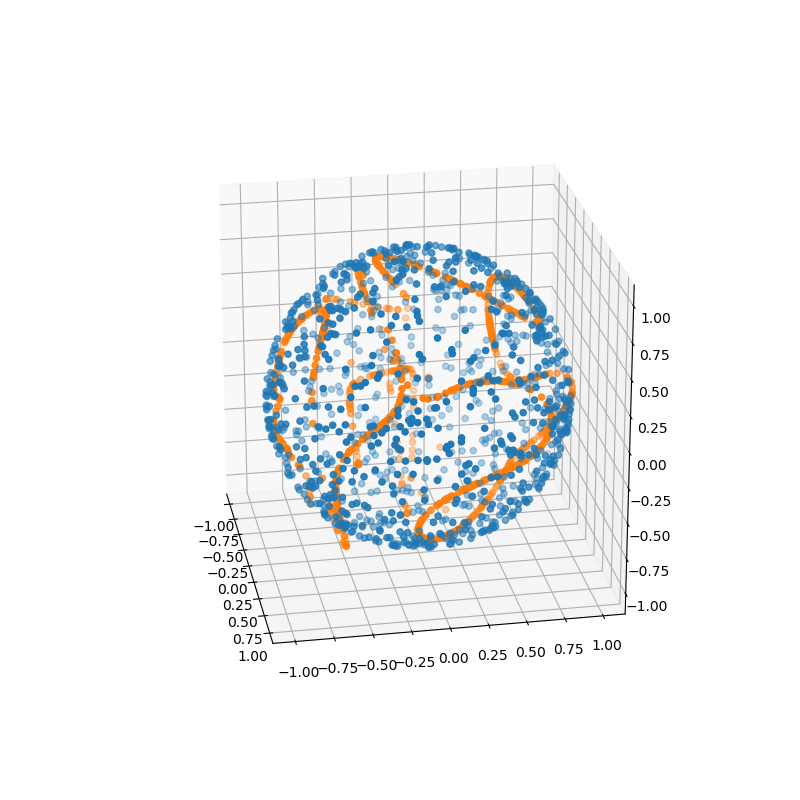

In [161]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax.scatter3D(X_fit[:, 0], X_fit[:, 1], X_fit[:, 2])

<IPython.core.display.Javascript object>


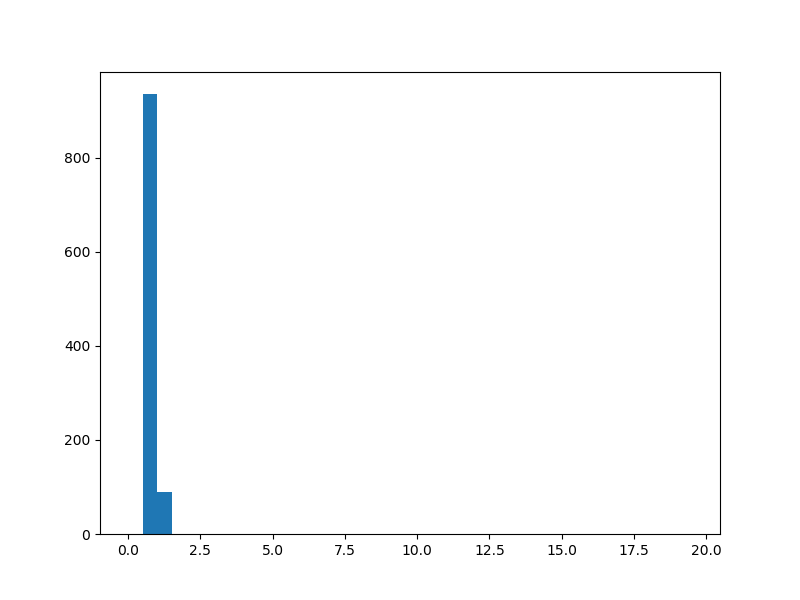

(array([   0.,  935.,   89.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
         18. ,  18.5,  19. ,  19.5]),
 <a list of 39 Patch objects>)

In [162]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 20, 0.5))

In [163]:
alpha = 2

Z_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(alpha * X).float())))
X_fit = model.decode(Z_fit).data.cpu().numpy()

<IPython.core.display.Javascript object>


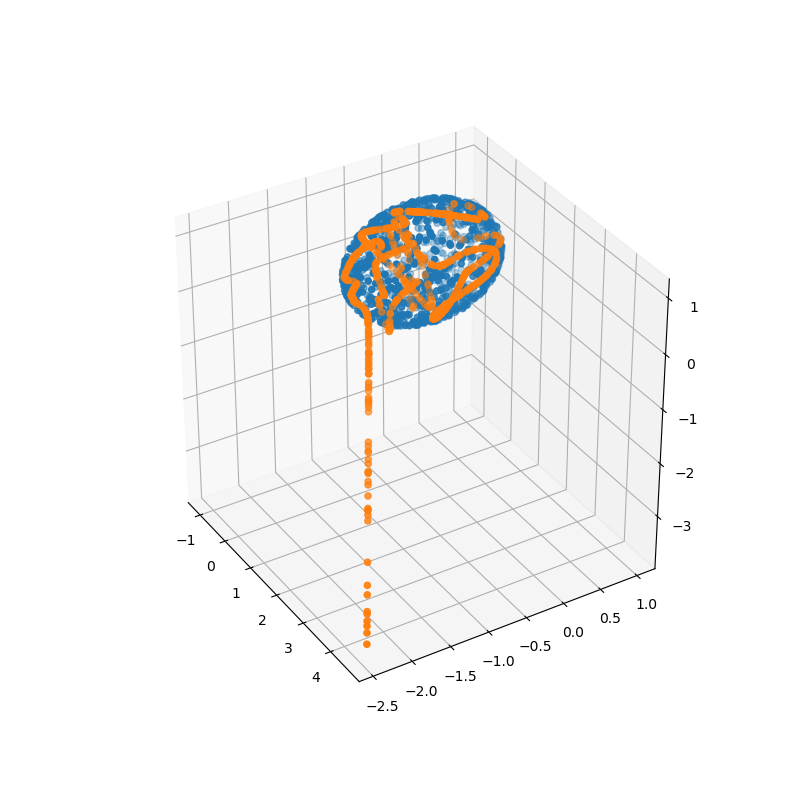

In [164]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax.scatter3D(X_fit[:, 0], X_fit[:, 1], X_fit[:, 2])

<IPython.core.display.Javascript object>


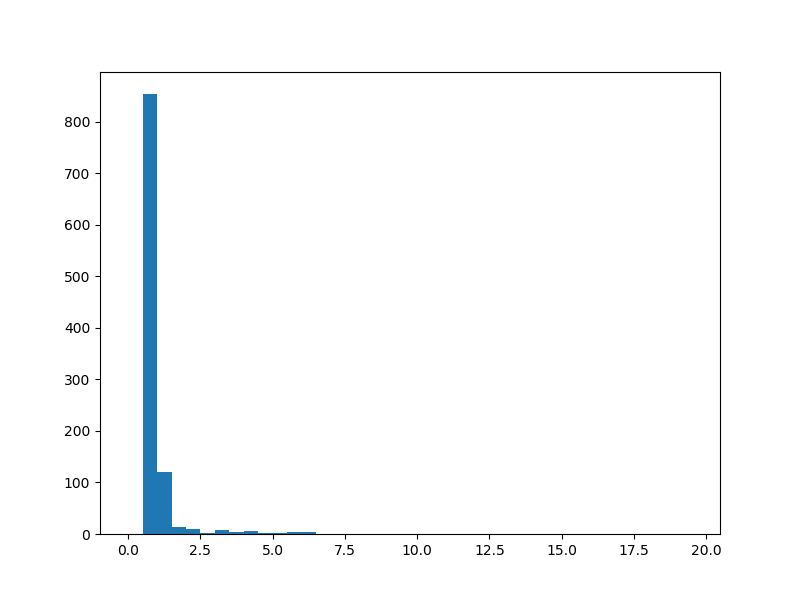

(array([   0.,  854.,  120.,   14.,   10.,    2.,    7.,    3.,    5.,
           1.,    1.,    4.,    3.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
         18. ,  18.5,  19. ,  19.5]),
 <a list of 39 Patch objects>)

In [165]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 20, 0.5))

**CAE**

In [295]:
epoch_count = 100000

model = cuda_wrapper(AE(n_features, hidden_dim=50, latent_dim=10))
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

contraction_factor = 1e-4

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_contraction_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.encode(X_batch_requires_grad)
        encoder_jacobian = []
        for k in range(Z_batch.size(1)):
            encoder_jacobian.append(
                autograd.grad([torch.sum(Z_batch[:, k])], [X_batch_requires_grad], create_graph=True)[0]
            )
        encoder_jacobian = torch.stack(encoder_jacobian, dim=-1)
        contraction_loss = contraction_factor * torch.sum(encoder_jacobian ** 2) / X_batch.size(0)
        cum_contraction_loss += contraction_loss.data[0]
        
        X_batch_fit = model.decode(Z_batch)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        (loss + contraction_loss).backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_contraction_loss = cum_contraction_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    if (epoch + 1) % 500 == 0:
        print(
            'epoch {}; loss = {:.4f}, contraction loss = {:.4f}, scalar product = {:.4f}'.format(
                epoch + 1, mean_loss, mean_contraction_loss, mean_scalar_product
            )
        )


epoch 500; loss = 0.0001, contraction loss = 0.0004, scalar product = 3.9174
epoch 1000; loss = 0.0000, contraction loss = 0.0002, scalar product = 3.9340
epoch 1500; loss = 0.0000, contraction loss = 0.0002, scalar product = 3.9262
epoch 2000; loss = 0.0008, contraction loss = 0.0001, scalar product = 3.9153
epoch 2500; loss = 0.0003, contraction loss = 0.0001, scalar product = 3.9053
epoch 3000; loss = 0.0004, contraction loss = 0.0001, scalar product = 3.9094
epoch 3500; loss = 0.0004, contraction loss = 0.0001, scalar product = 3.9141
epoch 4000; loss = 0.0000, contraction loss = 0.0001, scalar product = 3.9043
epoch 4500; loss = 0.0001, contraction loss = 0.0001, scalar product = 3.8982
epoch 5000; loss = 0.0002, contraction loss = 0.0001, scalar product = 3.8763
epoch 5500; loss = 0.0001, contraction loss = 0.0001, scalar product = 3.8759
epoch 6000; loss = 0.0000, contraction loss = 0.0001, scalar product = 3.8575
epoch 6500; loss = 0.0000, contraction loss = 0.0001, scalar prod

epoch 52500; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.4820
epoch 53000; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.4672
epoch 53500; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.4501
epoch 54000; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.4318
epoch 54500; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.4176
epoch 55000; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.3981
epoch 55500; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.3796
epoch 56000; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.3635
epoch 56500; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.3454
epoch 57000; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.3266
epoch 57500; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.3091
epoch 58000; loss = 0.0000, contraction loss = 0.0000, scalar product = 2.2905
epoch 58500; loss = 0.0000, contraction loss = 0.000

In [297]:
Z_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(X).float())))
X_fit = model.decode(Z_fit).data.cpu().numpy()
Z_fit = Z_fit.data.cpu().numpy()

<IPython.core.display.Javascript object>


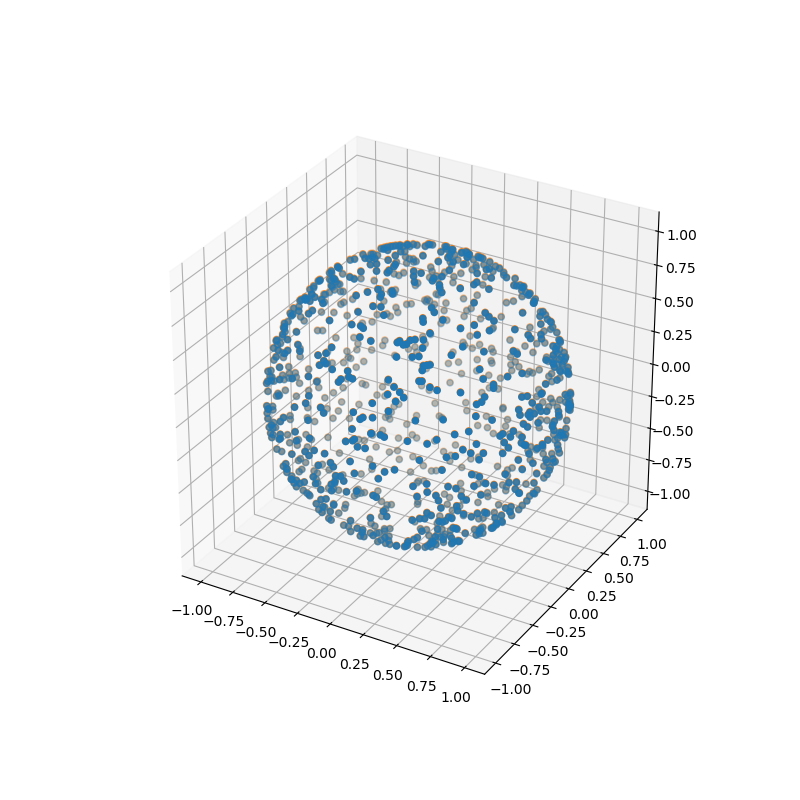

In [298]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax.scatter3D(X_fit[:, 0], X_fit[:, 1], X_fit[:, 2])

<IPython.core.display.Javascript object>


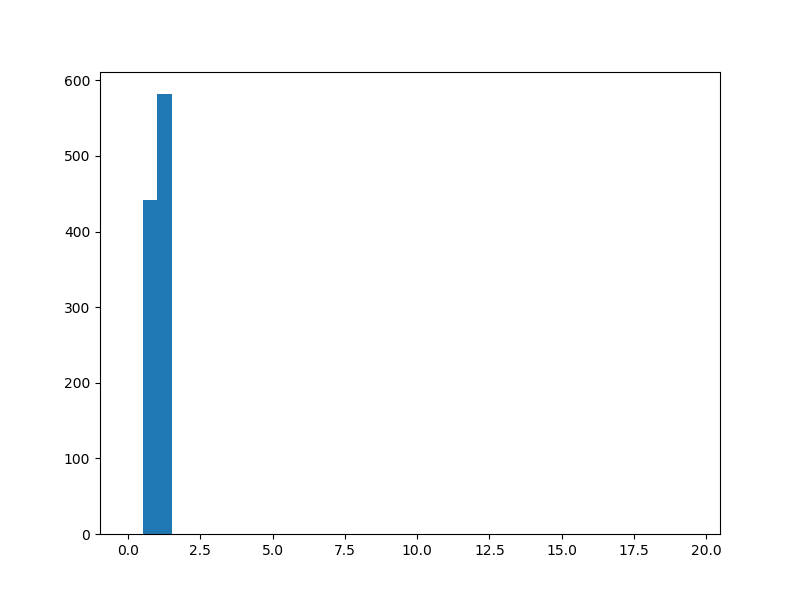

(array([   0.,  442.,  582.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
         18. ,  18.5,  19. ,  19.5]),
 <a list of 39 Patch objects>)

In [299]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 20, 0.5))

In [300]:
Z_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(X_test).float())))
X_fit = model.decode(Z_fit).data.cpu().numpy()

<IPython.core.display.Javascript object>


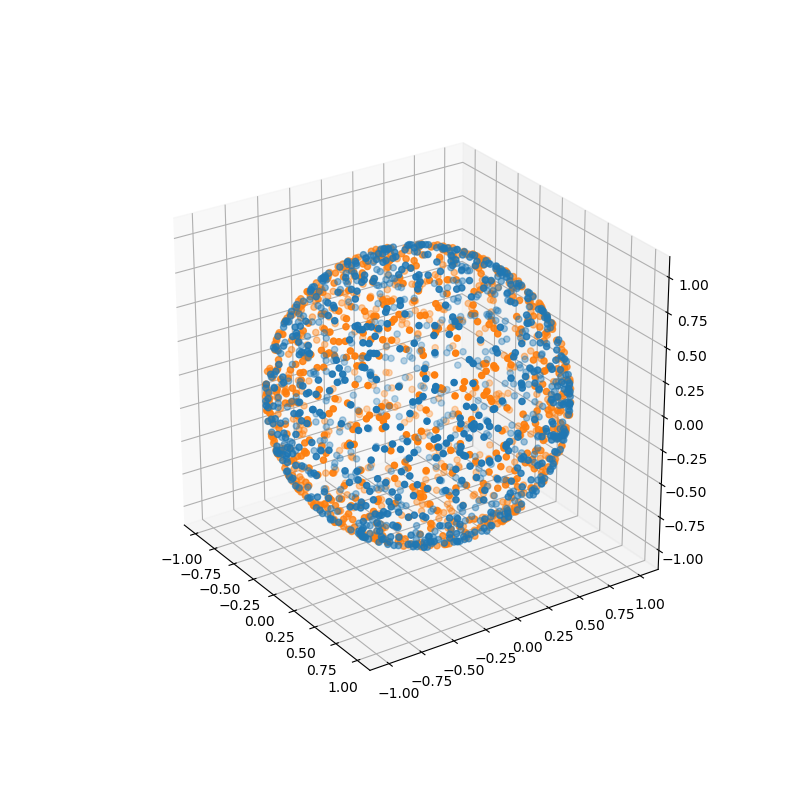

In [301]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax.scatter3D(X_fit[:, 0], X_fit[:, 1], X_fit[:, 2])

<IPython.core.display.Javascript object>


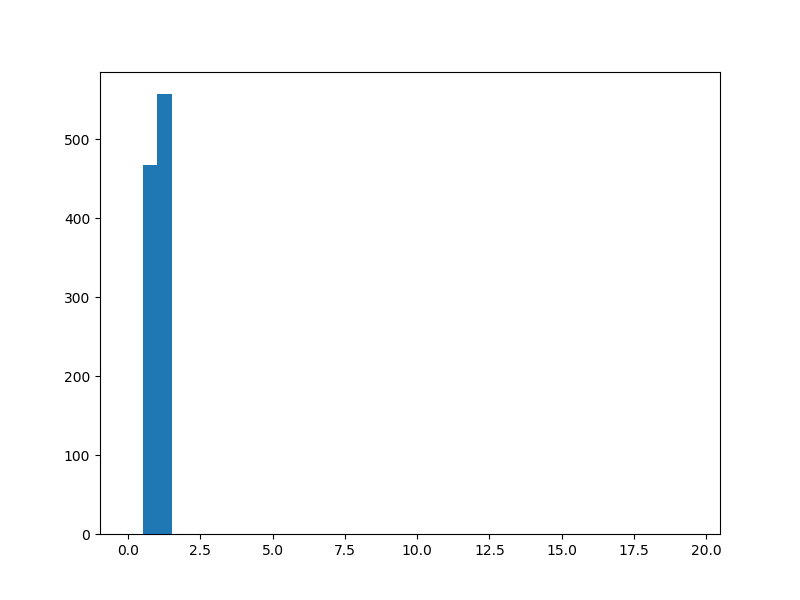

(array([   0.,  467.,  557.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
         18. ,  18.5,  19. ,  19.5]),
 <a list of 39 Patch objects>)

In [302]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 20, 0.5))

In [306]:
Z_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(X_test + 0.5 * np.random.normal(size=X_test.shape)).float())))
X_fit = model.decode(Z_fit).data.cpu().numpy()

<IPython.core.display.Javascript object>


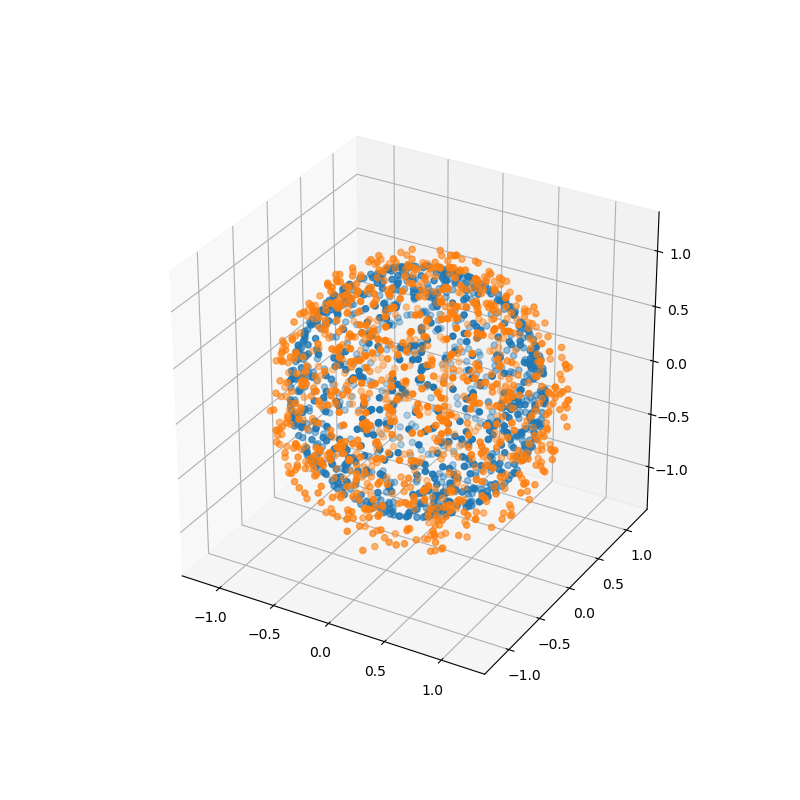

In [307]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax.scatter3D(X_fit[:, 0], X_fit[:, 1], X_fit[:, 2])

<IPython.core.display.Javascript object>


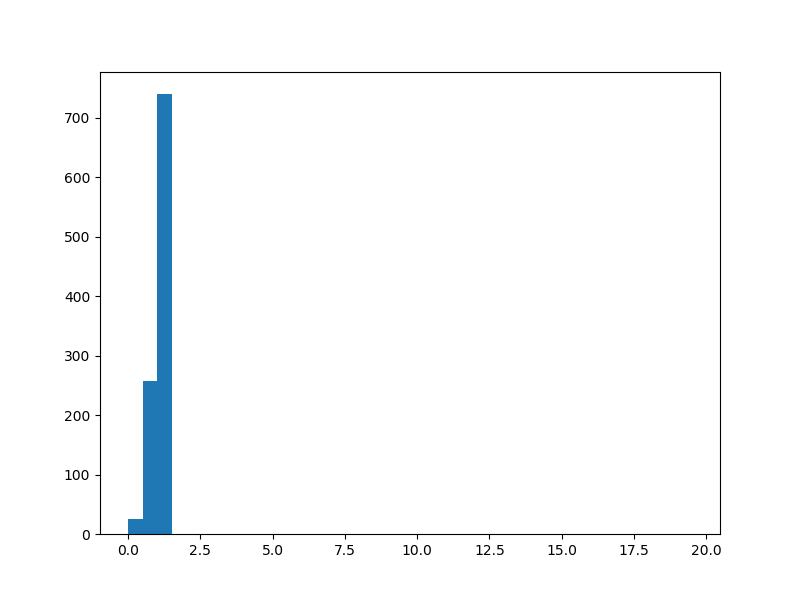

(array([  26.,  258.,  740.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
         18. ,  18.5,  19. ,  19.5]),
 <a list of 39 Patch objects>)

In [308]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 20, 0.5))

**VAE**

In [166]:
def kl(q_distr, p_distr):
    """
    Вычисляется KL-дивергенция KL(q || p) между n парами гауссиан.
    Вход: q_distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: p_distr, tuple(Variable, Varable). Аналогично.
    Возвращаемое значение: Variable, вектор размерности n, каждое значение которого - 
    - KL-дивергенция между соответствующей парой распределений.
    """
    mu_q, sigma_q = q_distr
    mu_p, sigma_p = p_distr
    n, d = mu_p.shape
    return 0.5 * (
        torch.sum(
            (sigma_q ** 2 + (mu_p - mu_q) ** 2) / sigma_p ** 2 - 1 + 2 * (torch.log(sigma_p) - torch.log(sigma_q)), dim=1
        )
    )

In [310]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_count=2):
        super(type(self), self).__init__()
        self.latent_dim = latent_dim
        
        self.proposal_network = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.proposal_network.append(nn.Linear(hidden_dim, hidden_dim))
            self.proposal_network.append(nn.Softplus())
        self.proposal_mu_head = nn.Linear(hidden_dim, latent_dim)
        self.proposal_sigma_head = nn.Linear(hidden_dim, latent_dim)

        self.generative_network = nn.ModuleList([
            nn.Linear(latent_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.generative_network.append(nn.Linear(hidden_dim, hidden_dim))
            self.generative_network.append(nn.Softplus())
        self.generative_mu_head = nn.Linear(hidden_dim, input_dim)
        self.generative_sigma_head = nn.Linear(hidden_dim, input_dim)

    def proposal_distr(self, x):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        for layer in self.proposal_network:
            x = layer(x)
        mu = self.proposal_mu_head(x)
        sigma = torch.exp(self.proposal_sigma_head(x))
        return mu, sigma

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        mu = cuda_wrapper(Variable(torch.zeros(n, self.latent_dim)))
        sigma = cuda_wrapper(Variable(torch.ones(n, self.latent_dim)))
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
        mu, sigma = distr
        n, d = mu.shape
        eps = cuda_wrapper(Variable(torch.normal(means=torch.zeros(n, K, d))))
        return (mu.view(n, 1, d) + sigma.view(n, 1, d) * eps).view(n * K, d)

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        return torch.normal(*self.prior_distr(num_samples))

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        for layer in self.generative_network:
            z = layer(z)
        mu = self.generative_mu_head(z)
        sigma = torch.exp(self.generative_sigma_head(z))
        return mu, sigma

    def batch_loss(self, batch, K=1):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        """
        n = batch.shape[0]
        q = self.proposal_distr(batch)
        zs = self.sample_latent(q, K)
        mu, sigma = self.generative_distr(zs)
        reconstruction_loss = torch.sum(((mu - batch) / sigma) ** 2 / 2 + torch.log(sigma), dim=1)
        regularization_loss = kl(q, self.prior_distr(n))
        return torch.mean(reconstruction_loss + regularization_loss)

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        return self.sample_latent(self.generative_distr(self.sample_prior(num_samples)))

In [615]:
epoch_count = 20000

model = cuda_wrapper(VAE(n_features, hidden_dim=20, latent_dim=10))
optimizer = optim.Adam(model.parameters())

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_scalar_product = 0
    cum_scalar_product_mean = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.sample_latent(model.proposal_distr(X_batch_requires_grad))
        X_batch_fit_mean, X_batch_fit_std = model.generative_distr(Z_batch)
        X_batch_fit = model.sample_latent((X_batch_fit_mean, X_batch_fit_std))
        loss = model.batch_loss(X_batch)
        cum_loss += loss.data[0]
        
        scalar_product_mean = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit_mean ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product_mean += torch.mean(scalar_product_mean)
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_scalar_product_mean = cum_scalar_product_mean / batch_count
    mean_scalar_product = cum_scalar_product / batch_count

    batch_gen = batch_generator(X_test, batch_size=256)
    cum_loss = 0
    cum_scalar_product = 0
    cum_scalar_product_mean = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.sample_latent(model.proposal_distr(X_batch_requires_grad))
        X_batch_fit_mean, X_batch_fit_std = model.generative_distr(Z_batch)
        X_batch_fit = model.sample_latent((X_batch_fit_mean, X_batch_fit_std))
        loss = model.batch_loss(X_batch)
        cum_loss += loss.data[0]
        
        scalar_product_mean = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit_mean ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product_mean += torch.mean(scalar_product_mean)
        cum_scalar_product += torch.mean(scalar_product)
        
        batch_count += 1
    mean_test_loss = cum_loss / batch_count
    mean_test_scalar_product_mean = cum_scalar_product_mean / batch_count
    mean_test_scalar_product = cum_scalar_product / batch_count
    
    if (epoch + 1) % 1000 == 0:
        print(
            'epoch {}; loss = {:.4f} : {:.4f}, scalar product = {:.4f} : {:.4f}, scalar product (mean) = {:.4f} : {:.4f}'.format(
                epoch + 1, mean_loss, mean_test_loss, 
                mean_scalar_product, mean_test_scalar_product, 
                mean_scalar_product_mean, mean_test_scalar_product_mean
            )
        )


epoch 1000; loss = -0.1508 : -0.1403, scalar product = 0.0003 : 0.0003, scalar product (mean) = 0.0000 : 0.0000
epoch 2000; loss = -0.1511 : -0.1573, scalar product = 0.0044 : 0.0045, scalar product (mean) = 0.0003 : 0.0003
epoch 3000; loss = -0.2584 : -0.2449, scalar product = 0.4767 : 0.4948, scalar product (mean) = 0.5261 : 0.4738
epoch 4000; loss = -0.4946 : -0.3788, scalar product = 1.0232 : 0.8742, scalar product (mean) = 0.9310 : 0.9198
epoch 5000; loss = -0.4839 : -0.4344, scalar product = 1.1134 : 0.8820, scalar product (mean) = 0.9739 : 0.9287
epoch 6000; loss = -0.4875 : -0.4402, scalar product = 1.1268 : 1.1414, scalar product (mean) = 1.0078 : 0.9545
epoch 7000; loss = -0.5012 : -0.4624, scalar product = 1.1310 : 0.9910, scalar product (mean) = 1.0286 : 0.9934
epoch 8000; loss = -0.4657 : -0.4980, scalar product = 1.0686 : 0.9985, scalar product (mean) = 1.0352 : 1.0094
epoch 9000; loss = -0.5116 : -0.4877, scalar product = 1.1404 : 0.8530, scalar product (mean) = 1.0319 :

KeyboardInterrupt: 

In [616]:
Z_fit = model.sample_latent(model.proposal_distr(cuda_wrapper(Variable(torch.from_numpy(X).float()))))
X_fit = model.sample_latent(model.generative_distr(Z_fit)).data.cpu().numpy()
Z_fit = Z_fit.data.cpu().numpy()

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


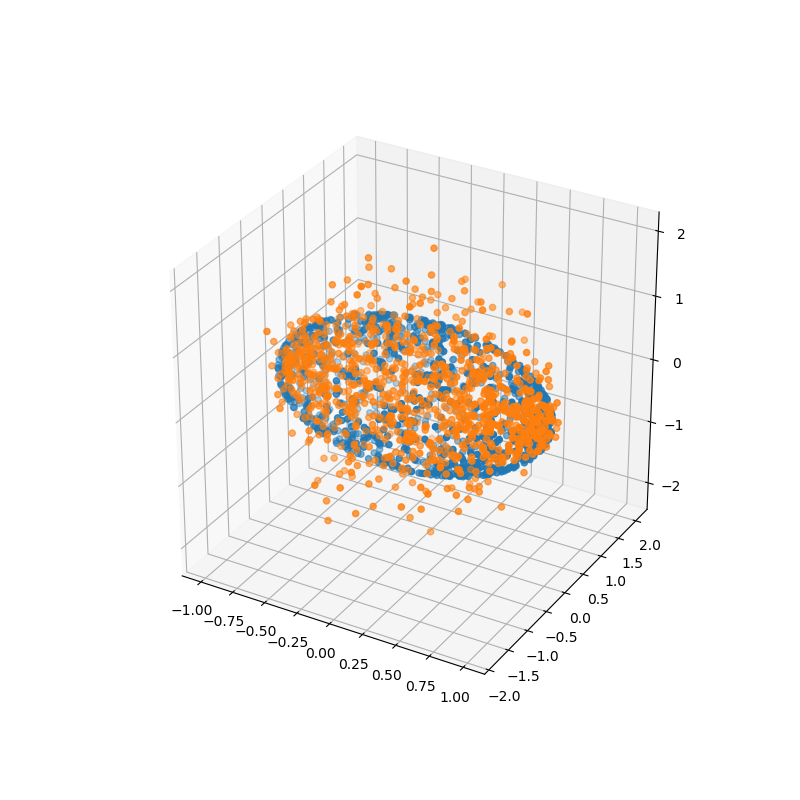

In [617]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax.scatter3D(X_fit[:, 0], X_fit[:, 1], X_fit[:, 2])

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


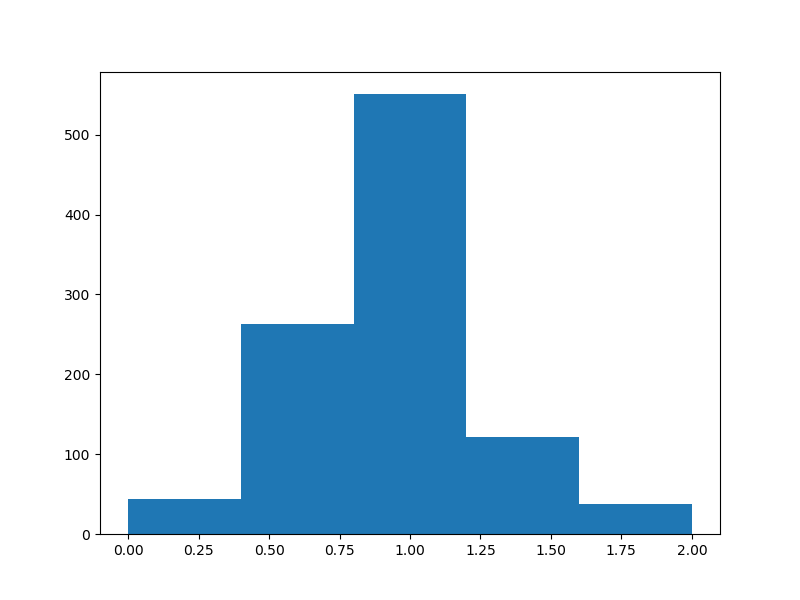

(array([  44.,  263.,  551.,  122.,   37.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [618]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

In [619]:
Z_fit = model.sample_latent(model.proposal_distr(cuda_wrapper(Variable(torch.from_numpy(X).float()))))
X_fit = model.generative_distr(Z_fit)[0].data.cpu().numpy()
Z_fit = Z_fit.data.cpu().numpy()

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


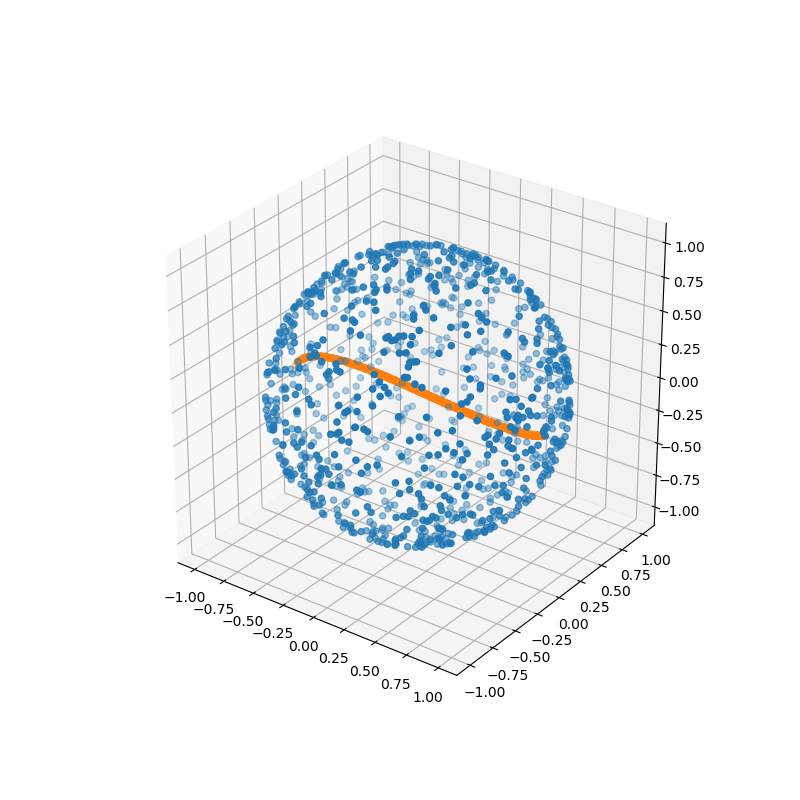

In [620]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax.scatter3D(X_fit[:, 0], X_fit[:, 1], X_fit[:, 2])

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


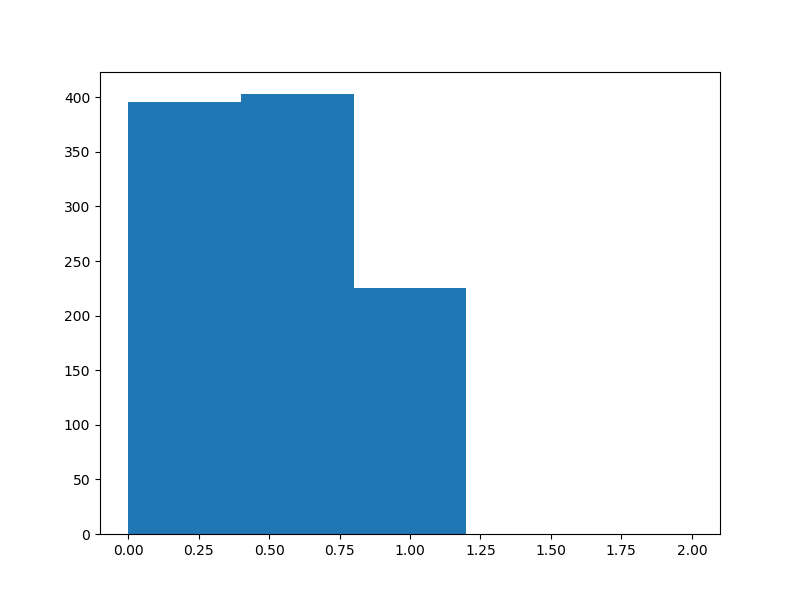

(array([ 396.,  403.,  225.,    0.,    0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 5 Patch objects>)

In [614]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 2.1, 0.4))

In [228]:
alpha = 2

Z_fit = model.sample_latent(model.proposal_distr(cuda_wrapper(Variable(torch.from_numpy(X * alpha).float()))))
X_fit = model.sample_latent(model.generative_distr(Z_fit)).data.cpu().numpy()


<IPython.core.display.Javascript object>


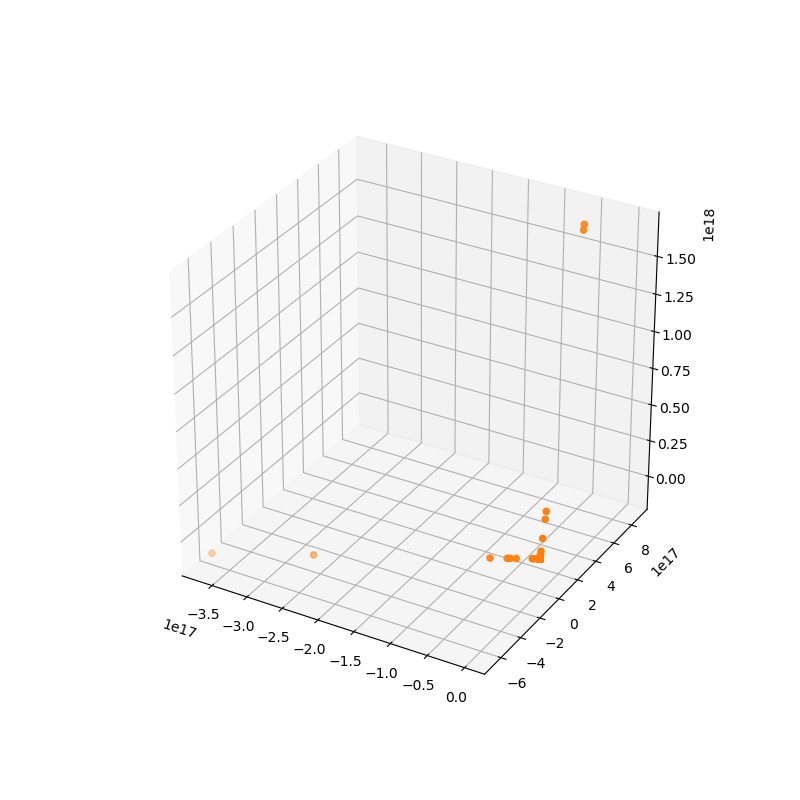

In [229]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax.scatter3D(X_fit[:, 0], X_fit[:, 1], X_fit[:, 2])

<IPython.core.display.Javascript object>


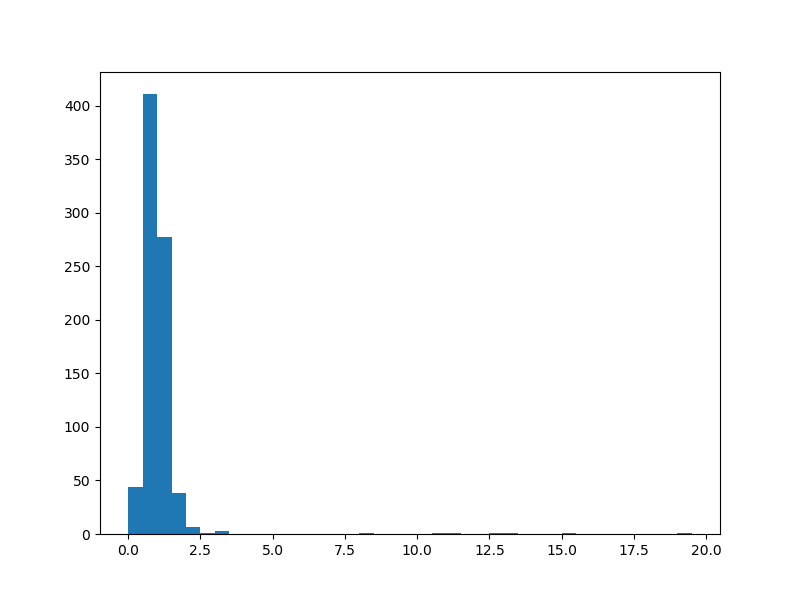

(array([  44.,  411.,  277.,   38.,    7.,    1.,    3.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,
           0.,    0.,    0.,    1.,    1.,    0.,    0.,    1.,    1.,
           0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.]),
 array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
          4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
          9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
         13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
         18. ,  18.5,  19. ,  19.5]),
 <a list of 39 Patch objects>)

In [230]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_fit ** 2, axis=1)), bins=np.arange(0, 20, 0.5))

<IPython.core.display.Javascript object>


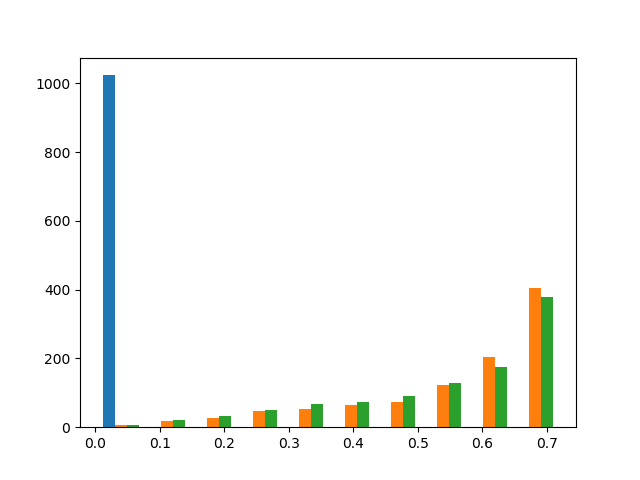

([array([ 1024.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([   6.,   19.,   28.,   47.,   54.,   65.,   73.,  123.,  203.,  406.]),
  array([   7.,   22.,   32.,   49.,   68.,   73.,   92.,  129.,  174.,  378.])],
 array([ 0.00423928,  0.07556588,  0.14689247,  0.21821906,  0.28954566,
         0.36087225,  0.43219884,  0.50352544,  0.57485203,  0.64617862,
         0.71750522]),
 <a list of 3 Lists of Patches objects>)

In [249]:
fig = plt.figure()
Z_fit = model.sample_latent(model.proposal_distr(cuda_wrapper(Variable(torch.from_numpy(X).float()))))
plt.hist(model.generative_distr(Z_fit)[1].data.cpu().numpy())

**VAE inside CAE**

In [360]:
epoch_count = 20000

latent_dim = 2
cae = cuda_wrapper(AE(n_features, hidden_dim=50, latent_dim=latent_dim))
loss_function = nn.MSELoss()
optimizer = optim.Adam(cae.parameters())

contraction_factor = 1e-4

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_contraction_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = cae.encode(X_batch_requires_grad)
        encoder_jacobian = []
        for k in range(Z_batch.size(1)):
            encoder_jacobian.append(
                autograd.grad([torch.sum(Z_batch[:, k])], [X_batch_requires_grad], create_graph=True)[0]
            )
        encoder_jacobian = torch.stack(encoder_jacobian, dim=-1)
        contraction_loss = contraction_factor * torch.sum(encoder_jacobian ** 2) / X_batch.size(0)
        cum_contraction_loss += contraction_loss.data[0]
        
        X_batch_fit = cae.decode(Z_batch)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        (loss + contraction_loss).backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_contraction_loss = cum_contraction_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    if (epoch + 1) % 500 == 0:
        print(
            'epoch {}; loss = {:.4f}, contraction loss = {:.4f}, scalar product = {:.4f}'.format(
                epoch + 1, mean_loss, mean_contraction_loss, mean_scalar_product
            )
        )


epoch 500; loss = 0.0944, contraction loss = 0.0009, scalar product = 4.0969
epoch 1000; loss = 0.0070, contraction loss = 0.0021, scalar product = 4.9466
epoch 1500; loss = 0.0026, contraction loss = 0.0012, scalar product = 6.9913
epoch 2000; loss = 0.0015, contraction loss = 0.0009, scalar product = 2.9710
epoch 2500; loss = 0.0008, contraction loss = 0.0007, scalar product = 2.0176
epoch 3000; loss = 0.0006, contraction loss = 0.0005, scalar product = 1.5042
epoch 3500; loss = 0.0005, contraction loss = 0.0004, scalar product = 1.2208
epoch 4000; loss = 0.0003, contraction loss = 0.0003, scalar product = 0.8918
epoch 4500; loss = 0.0003, contraction loss = 0.0003, scalar product = 1.2351
epoch 5000; loss = 0.0002, contraction loss = 0.0002, scalar product = 0.7911
epoch 5500; loss = 0.0002, contraction loss = 0.0002, scalar product = 0.8632
epoch 6000; loss = 0.0002, contraction loss = 0.0002, scalar product = 0.5357
epoch 6500; loss = 0.0001, contraction loss = 0.0002, scalar prod

In [361]:
Z_fit = cae.encode(cuda_wrapper(Variable(torch.from_numpy(X).float()))).data.cpu().numpy()

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


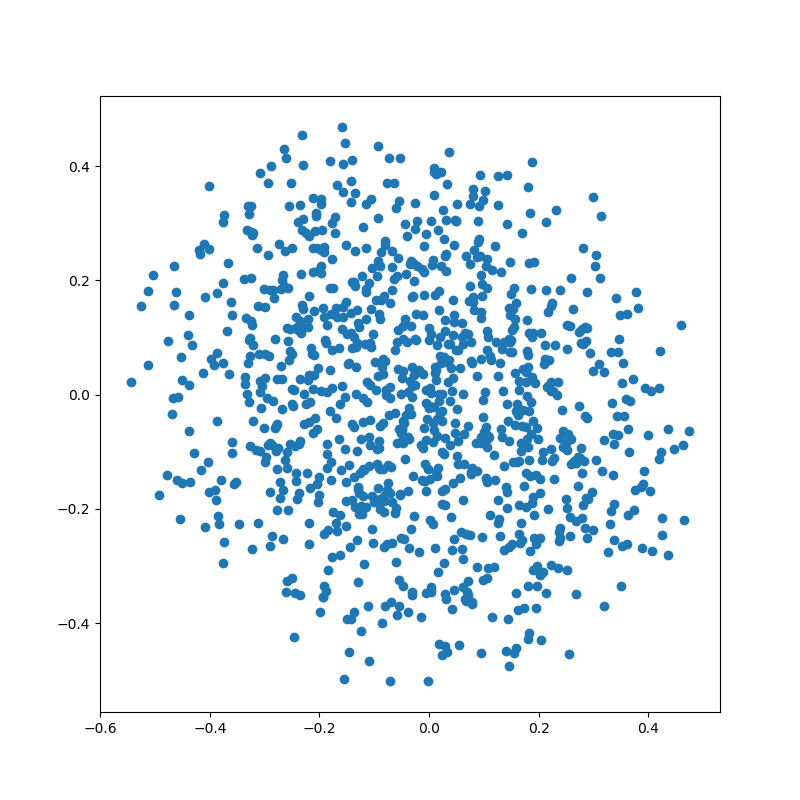

In [364]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()

ax.scatter(Z_fit[:, 0], Z_fit[:, 1])

In [365]:
epoch_count = 20000

vae_inside = cuda_wrapper(VAE(latent_dim, hidden_dim=50, latent_dim=2))
optimizer = optim.Adam(vae_inside.parameters())

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        Z_batch = cae.encode(X_batch)

        loss = vae_inside.batch_loss(Z_batch)
        cum_loss += loss.data[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    if (epoch + 1) % 500 == 0:
        print(
            'epoch {}; loss = {:.4f}'.format(
                epoch + 1, mean_loss
            )
        )


epoch 500; loss = -2.1535
epoch 1000; loss = -2.1398
epoch 1500; loss = -2.1480
epoch 2000; loss = -2.2119
epoch 2500; loss = -2.1673
epoch 3000; loss = -2.1885
epoch 3500; loss = -2.1487
epoch 4000; loss = -2.1957
epoch 4500; loss = -2.1975
epoch 5000; loss = -2.1752
epoch 5500; loss = -2.1540
epoch 6000; loss = -2.2068
epoch 6500; loss = -2.2314
epoch 7000; loss = -2.1517
epoch 7500; loss = -2.1729
epoch 8000; loss = -2.1879
epoch 8500; loss = -2.2078
epoch 9000; loss = -2.1610
epoch 9500; loss = -2.1907
epoch 10000; loss = -2.1917
epoch 10500; loss = -2.1775
epoch 11000; loss = -2.2154
epoch 11500; loss = -2.1812
epoch 12000; loss = -2.2472
epoch 12500; loss = -2.1484
epoch 13000; loss = -2.2069
epoch 13500; loss = -2.1730
epoch 14000; loss = -2.1611
epoch 14500; loss = -2.1983
epoch 15000; loss = -2.2255
epoch 15500; loss = -2.2182
epoch 16000; loss = -2.1668
epoch 16500; loss = -2.1888
epoch 17000; loss = -2.2056
epoch 17500; loss = -2.1977
epoch 18000; loss = -2.1508
epoch 18500;

In [366]:
Z_gen = vae_inside.generate_samples(n_samples)
X_gen = cae.decode(Z_gen)

In [367]:
X_gen_requires_grad = Variable(X_gen.data, requires_grad=True)
X_gen_fit = cae(X_gen_requires_grad)

scalar_product = torch.sum(
    autograd.grad(
        [torch.sum(X_gen_fit ** 2)], [X_gen_requires_grad], retain_graph=True
    )[0].data ** 2, dim=1
)
print(torch.mean(scalar_product))

321.2150573730469


/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


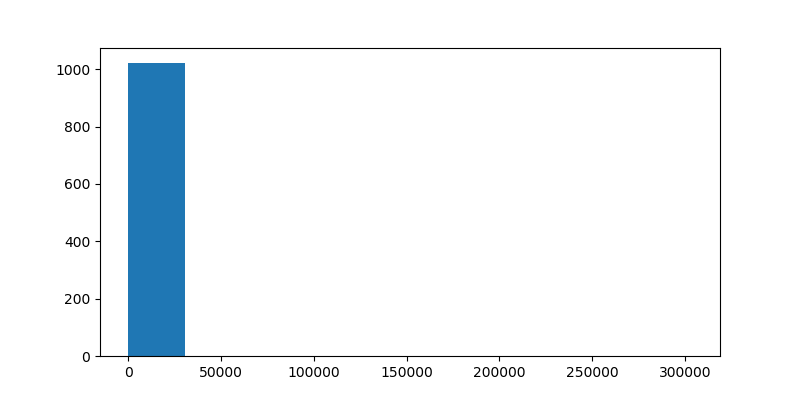

(array([  1.02300000e+03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  5.92907043e-07,   3.03770813e+04,   6.07541625e+04,
          9.11312438e+04,   1.21508325e+05,   1.51885406e+05,
          1.82262488e+05,   2.12639569e+05,   2.43016650e+05,
          2.73393731e+05,   3.03770812e+05]),
 <a list of 10 Patch objects>)

In [368]:
fig = plt.figure(figsize=(8,4))
plt.hist(scalar_product.cpu().numpy())

In [369]:
Z_fit = cae.encode(cuda_wrapper(Variable(torch.from_numpy(X).float()))).data.cpu().numpy()
Z_gen = Z_gen.data.cpu().numpy()

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


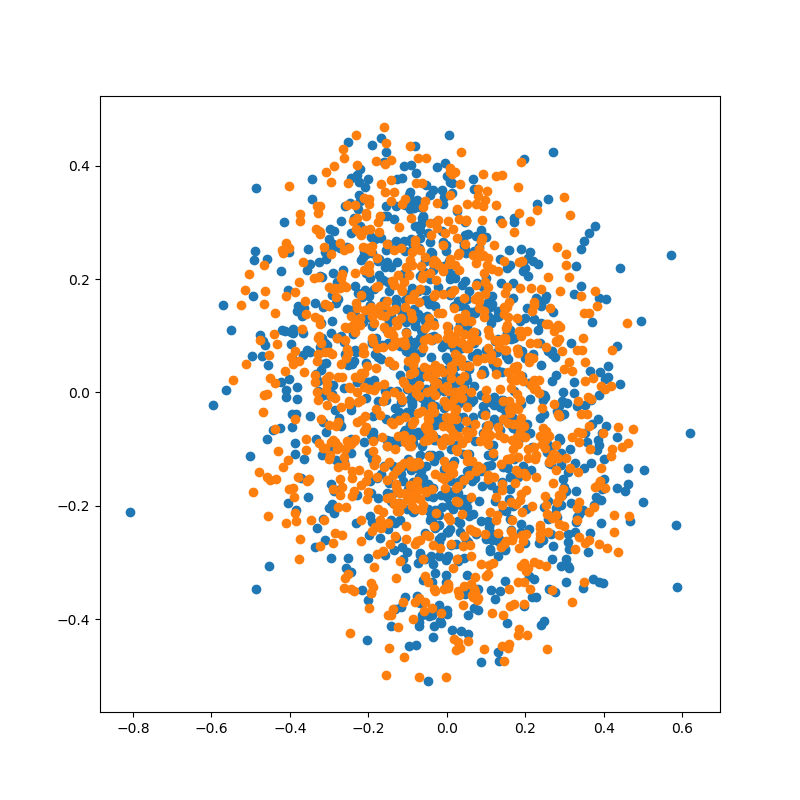

In [373]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()

ax.scatter(Z_gen[:, 0], Z_gen[:, 1])
ax.scatter(Z_fit[:, 0], Z_fit[:, 1])

In [374]:
X_gen = X_gen.data.cpu().numpy()
X_gen_fit = X_gen_fit.data.cpu().numpy()

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


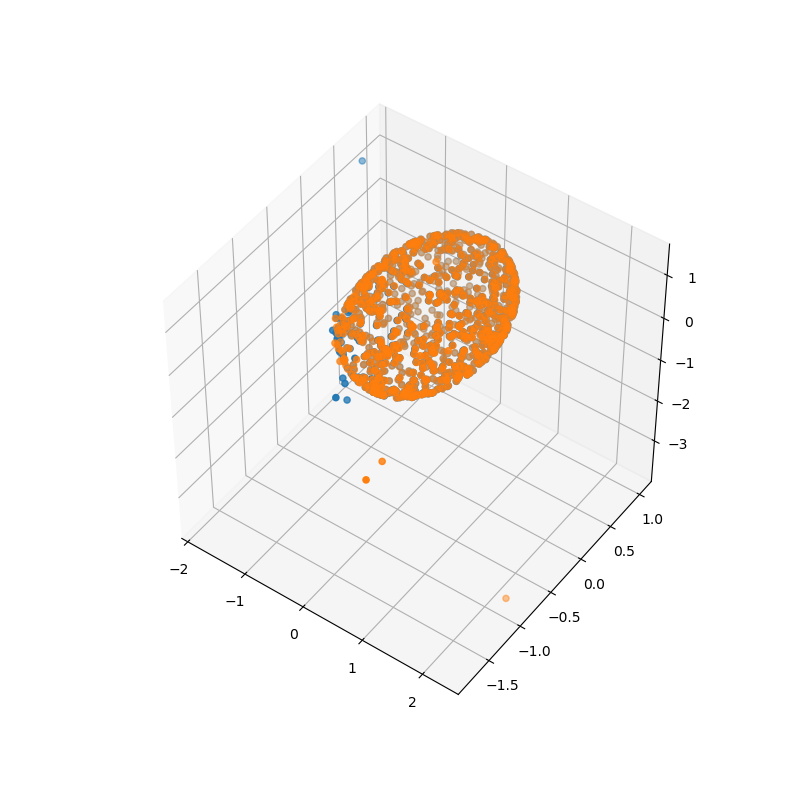

In [375]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X_gen[:, 0], X_gen[:, 1], X_gen[:, 2])
ax.scatter3D(X_gen_fit[:, 0], X_gen_fit[:, 1], X_gen_fit[:, 2])

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


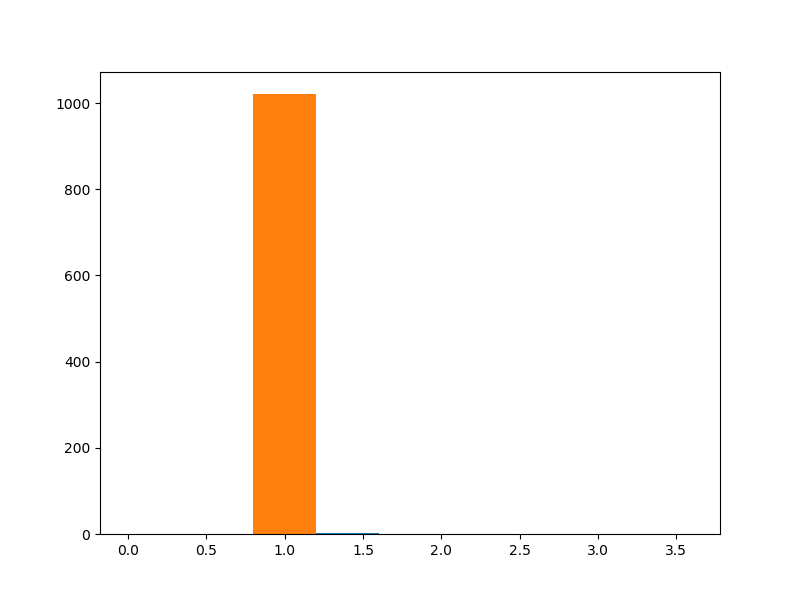

(array([  0.00000000e+00,   0.00000000e+00,   1.02100000e+03,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6]),
 <a list of 9 Patch objects>)

In [379]:
fig = plt.figure(figsize=(8,6))

plt.hist(np.sqrt(np.sum(X_gen ** 2, axis=1)), bins=np.arange(0, 4, 0.4))
plt.hist(np.sqrt(np.sum(X_gen_fit ** 2, axis=1)), bins=np.arange(0, 4, 0.4))

In [311]:
epoch_count = 50000

latent_dim = 8
cae = cuda_wrapper(AE(n_features, hidden_dim=50, latent_dim=latent_dim))
loss_function = nn.MSELoss()
optimizer = optim.Adam(cae.parameters())

contraction_factor = 1e-3

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_contraction_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = cae.encode(X_batch_requires_grad)
        encoder_jacobian = []
        for k in range(Z_batch.size(1)):
            encoder_jacobian.append(
                autograd.grad([torch.sum(Z_batch[:, k])], [X_batch_requires_grad], create_graph=True)[0]
            )
        encoder_jacobian = torch.stack(encoder_jacobian, dim=-1)
        contraction_loss = contraction_factor * torch.sum(encoder_jacobian ** 2) / X_batch.size(0)
        cum_contraction_loss += contraction_loss.data[0]
        
        X_batch_fit = cae.decode(Z_batch)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        (loss + contraction_loss).backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_contraction_loss = cum_contraction_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    if (epoch + 1) % 500 == 0:
        print(
            'epoch {}; loss = {:.4f}, contraction loss = {:.4f}, scalar product = {:.4f}'.format(
                epoch + 1, mean_loss, mean_contraction_loss, mean_scalar_product
            )
        )


epoch 500; loss = 0.0004, contraction loss = 0.0010, scalar product = 3.9127
epoch 1000; loss = 0.0000, contraction loss = 0.0007, scalar product = 3.9628
epoch 1500; loss = 0.0001, contraction loss = 0.0005, scalar product = 3.9425
epoch 2000; loss = 0.0006, contraction loss = 0.0005, scalar product = 3.9803
epoch 2500; loss = 0.0021, contraction loss = 0.0004, scalar product = 3.9661
epoch 3000; loss = 0.0000, contraction loss = 0.0004, scalar product = 3.9530
epoch 3500; loss = 0.0000, contraction loss = 0.0003, scalar product = 3.9521
epoch 4000; loss = 0.0000, contraction loss = 0.0003, scalar product = 3.9462
epoch 4500; loss = 0.0000, contraction loss = 0.0003, scalar product = 3.9448
epoch 5000; loss = 0.0000, contraction loss = 0.0003, scalar product = 3.9372
epoch 5500; loss = 0.0000, contraction loss = 0.0002, scalar product = 3.9365
epoch 6000; loss = 0.0000, contraction loss = 0.0002, scalar product = 3.9247
epoch 6500; loss = 0.0000, contraction loss = 0.0002, scalar prod

epoch 52500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.3289
epoch 53000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.3040
epoch 53500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.2763
epoch 54000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.2476
epoch 54500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.2244
epoch 55000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.1951
epoch 55500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.1703
epoch 56000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.1473
epoch 56500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.1222
epoch 57000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.0986
epoch 57500; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.0723
epoch 58000; loss = 0.0000, contraction loss = 0.0000, scalar product = 1.0476
epoch 58500; loss = 0.0000, contraction loss = 0.000

**AE with sparse VD**

In [405]:
class FeatureSparsifier(nn.Module):
    def __init__(self, features, threshold):
        super(type(self), self).__init__()
        # in_features int
        # out_features int 
        # threshold float
        self.threshold = threshold

        # =======================================
        # Создайте параметры модели -- объекты класса Parameter
        # W размера (out_features x in_features)
        # log_sigma размера (out_features x in_features)
        # bias размера (1, out_features)
        # =======================================
        
        self.W = nn.Parameter(torch.zeros(features))
        self.log_sigma = nn.Parameter(torch.zeros(features))
        
        self.reset_parameters()

    def reset_parameters(self):
        # =======================================
        # Инициализируйте параметры модели
        # W -- нормальный случайный шум с центром в 0 и маленькой дисперсией
        # log_sigma -- маленьким значением ~ -5 
        # bias -- можно 0
        # =======================================    
        
        self.W.data = torch.normal(std=torch.zeros_like(self.W.data)+0.01)
        self.log_sigma.data = torch.zeros_like(self.log_sigma.data) - 5
        
    def forward(self, x):
        # =======================================
        # x: Variable containing: [torch.FloatTensor of size batch_size x in_features]
        # Return: type: Variable containing [torch.FloatTensor of size batch_size x out_features]
        # ----------------------------------------
        # Тут нужно написать forward шаг для Sparse VD слоя для минибатча объектов x
        # На этапе обучения: Вернуть семпл активаций с помощью Local Reparametrization Trick 
        # На этапе тестирования: Вернуть средние активации, посчитанные с обрезанными весами 
        # Правило обрезания весов: alpha_ij < self.threshold ====> w_ij = 0
        # ----------------------------------------
        # Клипинг alpha_ij, например torch.clamp(self.log_alpha, -10, 10) может улучшить стабильность 
        # Чтобы не встретить nan-ы используйте трюк log(a) = log(a + 1e-8)
        # ======================================= 
        
        if self.training:
            eps = Variable(torch.normal(means=torch.zeros_like(self.W.data)))
            theta = self.W + eps * torch.exp(self.log_sigma)
            return x * theta
        else:
            self.log_alpha = torch.clamp(2 * self.log_sigma.data - torch.log(self.W.data ** 2 + 1e-8), -10, 10)
            #alpha = torch.exp(self.log_alpha)
            W_clipped = Variable(self.W.data * (self.log_alpha < self.threshold).float())
            return x * W_clipped
        
    def kl_reg(self):
        # =======================================
        # Вернуть суммарную KL дивергенцию для всех параметров слоя 
        # Return: Variable containing: [torch.FloatTensor of size 1]
        # =======================================
        k1, k2, k3 = 0.63576, 1.87320, 1.48695
        self.log_alpha = torch.clamp(2 * self.log_sigma - torch.log(self.W ** 2 + 1e-8), -100, 100)
        return -torch.sum(k1 * F.sigmoid(k2 + k3 * self.log_alpha) - 0.5 * torch.log(1 + torch.exp(-self.log_alpha)))

In [406]:
class SparseLatentAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_count=2, threshold=3):
        super(type(self), self).__init__()

        self.encoder = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.encoder.append(nn.Linear(hidden_dim, hidden_dim))
            self.encoder.append(nn.Softplus())
        self.encoder.append(nn.Linear(hidden_dim, latent_dim))
        self.encoder.append(FeatureSparsifier(latent_dim, threshold))

        self.decoder = nn.ModuleList([
            nn.Linear(latent_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.decoder.append(nn.Linear(hidden_dim, hidden_dim))
            self.decoder.append(nn.Softplus())
        self.decoder.append(nn.Linear(hidden_dim, input_dim))

    def forward(self, X):
        Z = self.encode(X)
        return self.decode(Z)
    
    def encode(self, X):
        Z = X
        for layer in self.encoder:
            Z = layer(Z)
        return Z
    
    def decode(self, Z):
        X = Z
        for layer in self.decoder:
            X = layer(X)
        return X

In [423]:
epoch_count = 50000

model = cuda_wrapper(SparseLatentAE(n_features, hidden_dim=50, latent_dim=10))
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epoch_count):
    kl_weight = float(np.clip(epoch / 30000, 0, 1))
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_penalty_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        X_batch_fit = model(X_batch_requires_grad)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        penalty_loss = 0
        for layer in model.modules():
            if isinstance(layer, FeatureSparsifier):
                penalty_loss += layer.kl_reg()
        penalty_loss = penalty_loss / X.shape[0]
        cum_penalty_loss += penalty_loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        (loss + kl_weight * penalty_loss).backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_penalty_loss = cum_penalty_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    if (epoch + 1) % 500 == 0:
        print(
            'epoch {}; loss = {:.4f}, penalty loss = {:.4f}, scalar product = {:.4f}'.format(
                epoch + 1, mean_loss, mean_penalty_loss, mean_scalar_product
            )
        )
        for layer in model.modules():
            if isinstance(layer, FeatureSparsifier):
                #print(np.percentile(layer.log_alpha.data.cpu().numpy(), 90))
                print(np.sort(layer.log_alpha.data.cpu().numpy()))


epoch 500; loss = 0.0002, penalty loss = 0.0348, scalar product = 3.5996
[-8.15432167 -8.02552032 -8.00741768 -7.10939407 -6.96682549 -6.96078634
 -6.91375351 -6.61219215 -6.39271402 -6.18711805]
epoch 1000; loss = 0.0002, penalty loss = 0.0315, scalar product = 3.4415
[-8.36862946 -8.20366096 -8.17984295 -6.75532198 -6.73744583 -6.14101267
 -5.71887589 -5.63747787 -4.64224911 -4.08384895]
epoch 1500; loss = 0.0004, penalty loss = 0.0181, scalar product = 3.6010
[-8.29226971 -7.96661997 -7.60260201 -6.38892269 -6.29432583 -5.56478405
  5.99685383  6.75638485  6.88944626  8.56969738]
epoch 2000; loss = 0.0004, penalty loss = 0.0163, scalar product = 3.2215
[-8.0548439  -7.748353   -7.0230751  -5.9026165  -5.84262276 -3.86273146
  5.66075611  7.51826477  7.77584839  8.80899334]
epoch 2500; loss = 0.0003, penalty loss = 0.0132, scalar product = 3.1969
[-7.89492893 -7.47157288 -6.83867645 -5.76048231 -5.45077181  7.17751217
  7.95121574  8.1873703   8.52764225  9.25400448]
epoch 3000; loss

epoch 21000; loss = 0.0015, penalty loss = 0.0016, scalar product = 0.0280
[ -4.80840778  -4.56847     -2.86822438   8.62264061   9.13180256
   9.53558636   9.84915733   9.89311409  10.04218197  10.11833572]
epoch 21500; loss = 0.0015, penalty loss = 0.0017, scalar product = 0.0386
[ -4.69084167  -4.64823437  -3.03025198   6.89847088   7.29620838
   7.87201881   8.67865849   9.43565559   9.62214184  10.03750515]
epoch 22000; loss = 0.0009, penalty loss = 0.0014, scalar product = 0.0345
[ -4.66717148  -4.40619755  -2.74452496   8.17827988   9.31804466
   9.62033558   9.88290215  10.00221825  10.25547695  10.26619053]
epoch 22500; loss = 0.0006, penalty loss = 0.0015, scalar product = 0.0138
[ -4.63832569  -4.46240425  -2.8521297    7.85036373   9.61640644
   9.81520653   9.85125732   9.98628712  10.10754585  10.16551208]
epoch 23000; loss = 0.0005, penalty loss = 0.0013, scalar product = 0.0203
[ -4.55185318  -4.32464123  -2.70770192   8.36998081   9.59735107
   9.82798576   9.82921696 

epoch 41000; loss = 0.0016, penalty loss = -0.0003, scalar product = 0.1062
[-2.9727602  -2.95148849 -2.50213361  6.16382504  6.68903828  8.49068069
  9.54389668  9.8532896   9.85907555  9.93215656]
epoch 41500; loss = 0.0007, penalty loss = -0.0003, scalar product = 0.0781
[ -3.0567894   -2.80567145  -2.65603852   9.16717815   9.71524906
   9.91315174   9.94803429   9.96527004  10.04492283  10.05244541]
epoch 42000; loss = 0.0014, penalty loss = -0.0002, scalar product = 0.1161
[ -2.98760843  -2.9182055   -2.71585631   8.68202591   9.33343792
   9.66074562   9.84344006   9.97574043  10.04010487  10.06240368]
epoch 42500; loss = 0.0016, penalty loss = -0.0001, scalar product = 0.0954
[ -3.12331438  -2.93456364  -2.85590029   9.12209225   9.75347614
   9.85370064   9.86488247   9.88153648   9.99628925  10.29264832]
epoch 43000; loss = 0.0026, penalty loss = -0.0004, scalar product = 0.1061
[-2.87621379 -2.78431225 -2.67266536  9.11523247  9.28404999  9.64234352
  9.64452457  9.67855549 

In [419]:
Z_fit = model.encode(cuda_wrapper(Variable(torch.from_numpy(X).float()))).data.cpu().numpy()

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


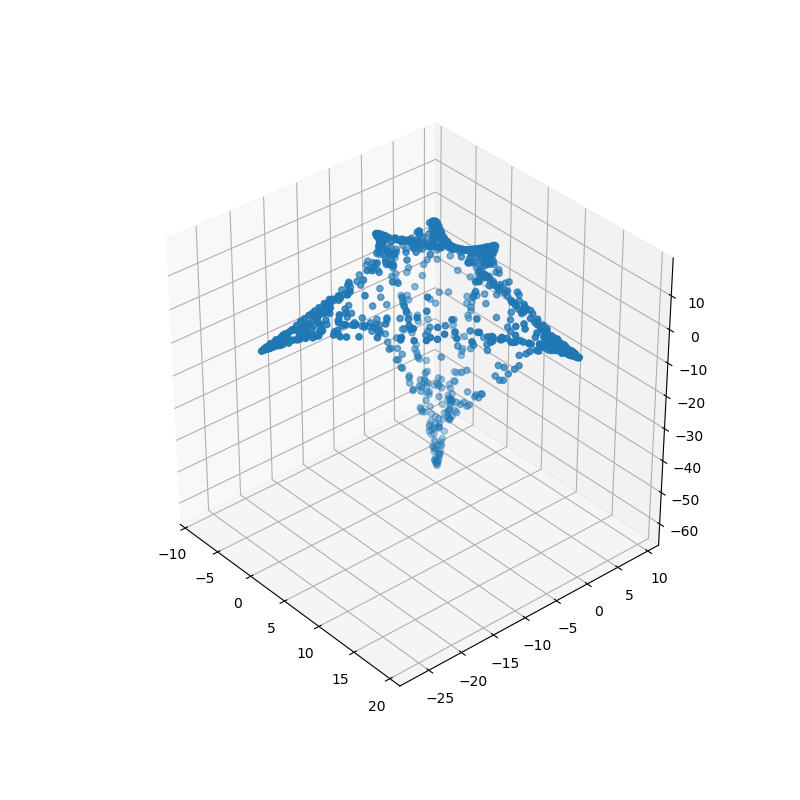

In [420]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(Z_fit[:, 0], Z_fit[:, 1], Z_fit[:, 2])

**WGAN-GP**

In [565]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, hidden_count=2):
        super(type(self), self).__init__()
        self.latent_dim = latent_dim

        self.decoder = nn.ModuleList([
            nn.Linear(latent_dim, hidden_dim),
            #nn.Dropout(p=0.5),
            nn.LeakyReLU(negative_slope=0.2)
        ])
        for _ in range(hidden_count-1):
            self.decoder.append(nn.Linear(hidden_dim, hidden_dim))
            #self.decoder.append(nn.Dropout(p=0.5)),
            self.decoder.append(nn.LeakyReLU(negative_slope=0.2))
        self.decoder.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, Z):
        X = Z
        for layer in self.decoder:
            X = layer(X)
        return X

In [566]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_count=2):
        super(type(self), self).__init__()

        self.layers = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim),
            #nn.Dropout(p=0.5),
            nn.LeakyReLU(negative_slope=0.2)
        ])
        for _ in range(hidden_count-1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            #self.layers.append(nn.Dropout(p=0.5)),
            self.layers.append(nn.LeakyReLU(negative_slope=0.2))
        self.layers.append(nn.Linear(hidden_dim, 1))

    def forward(self, X):
        Z = X
        for layer in self.layers:
            Z = layer(Z)
        return Z

In [588]:
epoch_count = 200000

generator = cuda_wrapper(Generator(output_dim=n_features, hidden_dim=50, latent_dim=1, hidden_count=2))
discriminator = cuda_wrapper(Discriminator(input_dim=n_features, hidden_dim=50, hidden_count=2))
generator_opt = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.9))
discriminator_opt = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.9))

reg_lambda = 2

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_generator_loss = 0
    cum_discriminator_loss = 0
    cum_value_batch_hat_grad_sqr_norm = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch_true = cuda_wrapper(Variable(X_batch))
        
        Z_batch_gen = cuda_wrapper(Variable(torch.normal(means=torch.zeros(X_batch.shape[0], generator.latent_dim))))
        X_batch_gen = generator(Z_batch_gen)

        value_batch_true = discriminator(X_batch_true)
        value_batch_gen = discriminator(X_batch_gen)
        
        discriminator_loss = -0.5 * torch.mean(
            value_batch_true - value_batch_gen
        )
        generator_loss = -torch.mean(value_batch_gen)
        cum_generator_loss += generator_loss.data[0]
        cum_discriminator_loss += discriminator_loss.data[0]
        
        do_generator_update = (epoch * X.shape[0] // X_batch.shape[0] + batch_count) % 100 == 0
        
        if do_generator_update:
            generator_opt.zero_grad()
            generator_loss.backward()
            generator_opt.step()
        else:
            eps = np.random.uniform()
            X_batch_hat = Variable(X_batch_true.data * eps + X_batch_gen.data * (1 - eps), requires_grad=True)
            value_batch_hat = discriminator(X_batch_hat)
            value_batch_hat_grad_sqr_norm = torch.sum(
                autograd.grad([torch.sum(value_batch_hat)], [X_batch_hat], create_graph=True)[0] ** 2, dim=-1
            )
            cum_value_batch_hat_grad_sqr_norm += torch.mean(value_batch_hat_grad_sqr_norm).data[0]
            reg_loss = (torch.sqrt(value_batch_hat_grad_sqr_norm) - 1) ** 2

            discriminator_opt.zero_grad()
            (discriminator_loss + reg_lambda * torch.mean(reg_loss)).backward()
            discriminator_opt.step()
        batch_count += 1
    mean_generator_loss = cum_generator_loss / batch_count
    mean_discriminator_loss = cum_discriminator_loss / batch_count
    if (epoch + 1) % 1000 == 0:
        print(
            'epoch {}; generator loss = {:.4f}, discriminator loss = {:.4f}'.format(
                epoch + 1, mean_generator_loss / np.log(4), mean_discriminator_loss / np.log(4)
            )
        )
        print(
            'generated smaples norm: mean = {:.2f}, std = {:.2f}'.format(
                torch.mean(torch.sqrt(torch.sum(X_batch_gen.data ** 2, dim=1))), 
                torch.std(torch.sqrt(torch.sum(X_batch_gen.data ** 2, dim=1)))
            )
        )
        print(cum_value_batch_hat_grad_sqr_norm / batch_count)


epoch 1000; generator loss = 0.0940, discriminator loss = -0.3525
generated smaples norm: mean = 0.29, std = 0.08
1.2645189464092255
epoch 2000; generator loss = 0.0463, discriminator loss = -0.3195
generated smaples norm: mean = 0.35, std = 0.17
1.1395686268806458
epoch 3000; generator loss = -0.0095, discriminator loss = -0.3026
generated smaples norm: mean = 0.47, std = 0.30
1.2204314470291138
epoch 4000; generator loss = 0.0882, discriminator loss = -0.2968
generated smaples norm: mean = 0.50, std = 0.32
1.191993087530136
epoch 5000; generator loss = 0.2953, discriminator loss = -0.2942
generated smaples norm: mean = 0.53, std = 0.33
1.1604523658752441
epoch 6000; generator loss = 0.4721, discriminator loss = -0.2939
generated smaples norm: mean = 0.53, std = 0.30
1.2182038724422455
epoch 7000; generator loss = 0.5819, discriminator loss = -0.2864
generated smaples norm: mean = 0.53, std = 0.28
1.1519995033740997
epoch 8000; generator loss = 0.6640, discriminator loss = -0.2824
gen

epoch 63000; generator loss = 0.8182, discriminator loss = -0.1652
generated smaples norm: mean = 0.82, std = 0.14
1.1020383536815643
epoch 64000; generator loss = 0.7576, discriminator loss = -0.1682
generated smaples norm: mean = 0.83, std = 0.12
1.0817166566848755
epoch 65000; generator loss = 0.8486, discriminator loss = -0.1634
generated smaples norm: mean = 0.83, std = 0.16
1.127278745174408
epoch 66000; generator loss = 0.9488, discriminator loss = -0.1669
generated smaples norm: mean = 0.86, std = 0.17
1.1032078862190247
epoch 67000; generator loss = 0.8975, discriminator loss = -0.1638
generated smaples norm: mean = 0.83, std = 0.11
1.1072902083396912
epoch 68000; generator loss = 0.8298, discriminator loss = -0.1646
generated smaples norm: mean = 0.86, std = 0.11
1.0735712945461273
epoch 69000; generator loss = 0.7099, discriminator loss = -0.1697
generated smaples norm: mean = 0.87, std = 0.17
1.0211013853549957
epoch 70000; generator loss = 0.7735, discriminator loss = -0.1

epoch 125000; generator loss = 0.4187, discriminator loss = -0.1360
generated smaples norm: mean = 0.90, std = 0.13
1.1565783023834229
epoch 126000; generator loss = 0.3370, discriminator loss = -0.1334
generated smaples norm: mean = 0.92, std = 0.16
1.0853137969970703
epoch 127000; generator loss = 0.4509, discriminator loss = -0.1355
generated smaples norm: mean = 0.91, std = 0.12
1.0518023669719696
epoch 128000; generator loss = 0.3415, discriminator loss = -0.1337
generated smaples norm: mean = 0.92, std = 0.12
1.0879237353801727
epoch 129000; generator loss = 0.3129, discriminator loss = -0.1364
generated smaples norm: mean = 0.90, std = 0.11
1.089727759361267
epoch 130000; generator loss = 0.3420, discriminator loss = -0.1365
generated smaples norm: mean = 0.91, std = 0.16
1.078500896692276
epoch 131000; generator loss = 0.2608, discriminator loss = -0.1346
generated smaples norm: mean = 0.92, std = 0.16
1.118786334991455
epoch 132000; generator loss = 0.2616, discriminator loss 

KeyboardInterrupt: 

In [589]:
X_batch_gen = X_batch_gen.data.cpu().numpy()

/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


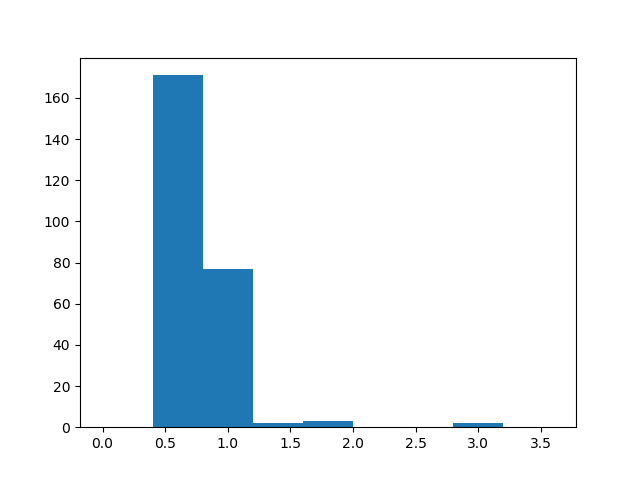

(array([   0.,  171.,   77.,    2.,    3.,    0.,    0.,    2.,    0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6]),
 <a list of 9 Patch objects>)

In [590]:
fig = plt.figure()
plt.hist(np.sum(X_batch_gen ** 2, axis=1), bins=np.arange(0, 4, 0.4))


/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


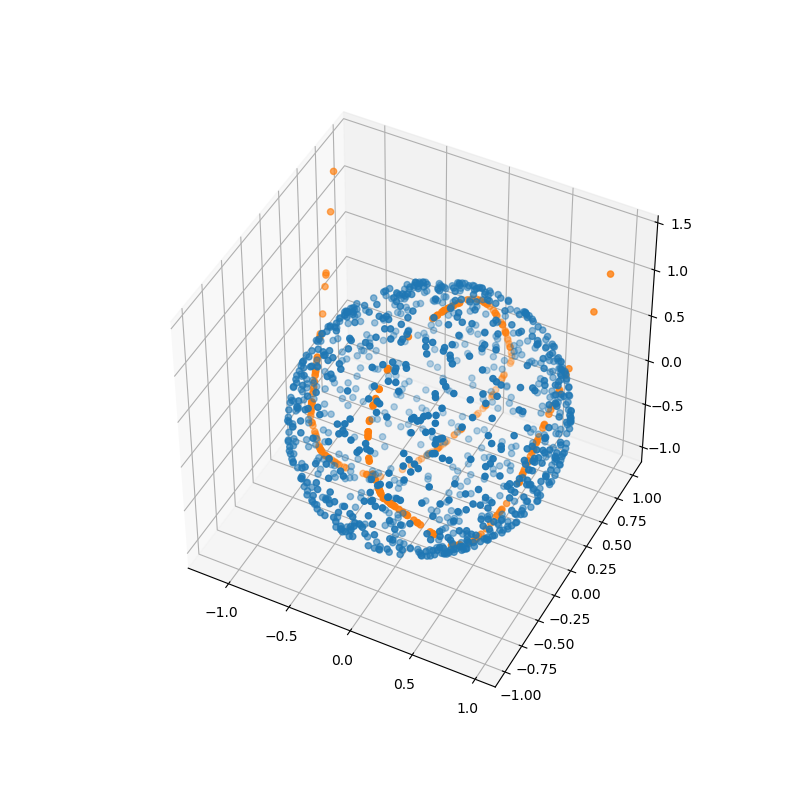

In [592]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax.scatter3D(X_batch_gen[:, 0], X_batch_gen[:, 1], X_batch_gen[:, 2])

**WGAN-GP inside CAE**

In [596]:
epoch_count = 50000

latent_dim = 10
cae = cuda_wrapper(AE(n_features, hidden_dim=50, latent_dim=latent_dim))
loss_function = nn.MSELoss()
optimizer = optim.Adam(cae.parameters())

contraction_factor = 1e-5

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_contraction_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.encode(X_batch_requires_grad)
        encoder_jacobian = []
        for k in range(Z_batch.size(1)):
            encoder_jacobian.append(
                autograd.grad([torch.sum(Z_batch[:, k])], [X_batch_requires_grad], create_graph=True)[0]
            )
        encoder_jacobian = torch.stack(encoder_jacobian, dim=-1)
        contraction_loss = contraction_factor * torch.sum(encoder_jacobian ** 2) / X_batch.size(0)
        cum_contraction_loss += contraction_loss.data[0]
        
        X_batch_fit = model.decode(Z_batch)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        (loss + contraction_loss).backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_contraction_loss = cum_contraction_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    
    batch_gen = batch_generator(X_test, batch_size=256)
    cum_loss = 0
    cum_contraction_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.encode(X_batch_requires_grad)
        encoder_jacobian = []
        for k in range(Z_batch.size(1)):
            encoder_jacobian.append(
                autograd.grad([torch.sum(Z_batch[:, k])], [X_batch_requires_grad], create_graph=True)[0]
            )
        encoder_jacobian = torch.stack(encoder_jacobian, dim=-1)
        contraction_loss = contraction_factor * torch.sum(encoder_jacobian ** 2) / X_batch.size(0)
        cum_contraction_loss += contraction_loss.data[0]
        
        X_batch_fit = model.decode(Z_batch)
        loss = loss_function(X_batch_fit, X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        batch_count += 1
    mean_test_loss = cum_loss / batch_count
    mean_test_contraction_loss = cum_contraction_loss / batch_count
    mean_test_scalar_product = cum_scalar_product / batch_count
    
    if (epoch + 1) % 1000 == 0:
        print(
            'epoch {}; loss = {:.4f} : {:.4f}, contraction loss = {:.4f} : {:.4f}, scalar product = {:.4f} : {:.4f}'.format(
                epoch + 1, mean_loss, mean_test_loss, 
                mean_contraction_loss, mean_test_contraction_loss, 
                mean_scalar_product, mean_test_scalar_product
            )
        )


epoch 1000; loss = 0.0009 : 0.0014, contraction loss = 0.0256 : 0.0194, scalar product = 0.1001 : 0.0794
epoch 2000; loss = 0.0014 : 0.0009, contraction loss = 0.0204 : 0.0191, scalar product = 0.0831 : 0.0795
epoch 3000; loss = 0.0015 : 0.0008, contraction loss = 0.0207 : 0.0219, scalar product = 0.0870 : 0.0909
epoch 4000; loss = 0.0006 : 0.0008, contraction loss = 0.0242 : 0.0173, scalar product = 0.0983 : 0.0712
epoch 5000; loss = 0.0013 : 0.0007, contraction loss = 0.0191 : 0.0204, scalar product = 0.0850 : 0.0819
epoch 6000; loss = 0.0008 : 0.0015, contraction loss = 0.0222 : 0.0232, scalar product = 0.0910 : 0.0951
epoch 7000; loss = 0.0010 : 0.0009, contraction loss = 0.0203 : 0.0227, scalar product = 0.0782 : 0.0895
epoch 8000; loss = 0.0011 : 0.0017, contraction loss = 0.0197 : 0.0158, scalar product = 0.0813 : 0.0701
epoch 9000; loss = 0.0017 : 0.0030, contraction loss = 0.0192 : 0.0229, scalar product = 0.0757 : 0.0973
epoch 10000; loss = 0.0008 : 0.0011, contraction loss =

KeyboardInterrupt: 

In [601]:
epoch_count = 200000

generator = cuda_wrapper(Generator(output_dim=latent_dim, hidden_dim=50, latent_dim=latent_dim, hidden_count=2))
discriminator = cuda_wrapper(Discriminator(input_dim=latent_dim, hidden_dim=50, hidden_count=2))
generator_opt = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.9))
discriminator_opt = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.9))

reg_lambda = 2

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_discriminator_loss = 0
    cum_scalar_product = 0
    cum_value_batch_hat_grad_sqr_norm = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch_true = cuda_wrapper(Variable(X_batch))
        Z_batch_true = cae.encode(X_batch_true)
        
        Z_batch_gen = generator(
            cuda_wrapper(Variable(torch.normal(means=torch.zeros(X_batch.shape[0], generator.latent_dim))))
        )
        X_batch_gen_requires_grad = Variable(cae.decode(Z_batch_gen).data, requires_grad=True)
        X_batch_gen_fit = cae(X_batch_gen_requires_grad)

        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_gen_fit ** 2)], [X_batch_gen_requires_grad]
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        value_batch_true = discriminator(Z_batch_true)
        value_batch_gen = discriminator(Z_batch_gen)
        
        discriminator_loss = -0.5 * torch.mean(
            value_batch_true - value_batch_gen
        )
        generator_loss = -torch.mean(value_batch_gen)
        cum_discriminator_loss += discriminator_loss.data[0]
        
        do_generator_update = (epoch * X.shape[0] // X_batch.shape[0] + batch_count) % 100 == 0
        
        if do_generator_update:
            generator_opt.zero_grad()
            generator_loss.backward()
            generator_opt.step()
        else:
            eps = np.random.uniform()
            Z_batch_hat = Variable(Z_batch_true.data * eps + Z_batch_gen.data * (1 - eps), requires_grad=True)
            value_batch_hat = discriminator(Z_batch_hat)
            value_batch_hat_grad_sqr_norm = torch.sum(
                autograd.grad([torch.sum(value_batch_hat)], [Z_batch_hat], create_graph=True)[0] ** 2, dim=-1
            )
            cum_value_batch_hat_grad_sqr_norm += torch.mean(value_batch_hat_grad_sqr_norm).data[0]
            reg_loss = (torch.sqrt(value_batch_hat_grad_sqr_norm) - 1) ** 2

            discriminator_opt.zero_grad()
            (discriminator_loss + reg_lambda * torch.mean(reg_loss)).backward()
            discriminator_opt.step()
        batch_count += 1
    mean_discriminator_loss = cum_discriminator_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count
    if (epoch + 1) % 1000 == 0:
        print(
            'epoch {}; discriminator loss = {:.4f}'.format(
                epoch + 1, mean_discriminator_loss
            )
        )
        print(
            'generated samples norm: mean = {:.2f}, std = {:.2f}'.format(
                torch.mean(torch.sqrt(torch.sum(X_batch_gen_requires_grad.data ** 2, dim=1))), 
                torch.std(torch.sqrt(torch.sum(X_batch_gen_requires_grad.data ** 2, dim=1)))
            )
        )
        print('scalar product = {:.4f}'.format(mean_scalar_product))
        print(cum_value_batch_hat_grad_sqr_norm / batch_count)
        print()


epoch 1000; discriminator loss = -0.6028
generated samples norm: mean = 0.92, std = 0.01
scalar product = 0.0000
1.2837210297584534

epoch 2000; discriminator loss = -0.4997
generated samples norm: mean = 0.92, std = 0.01
scalar product = 0.0000
1.2333589494228363

epoch 3000; discriminator loss = -0.4027
generated samples norm: mean = 0.92, std = 0.01
scalar product = 0.0000
1.1906313300132751

epoch 4000; discriminator loss = -0.3096
generated samples norm: mean = 0.93, std = 0.01
scalar product = 0.0000
1.1485538184642792

epoch 5000; discriminator loss = -0.2164
generated samples norm: mean = 0.93, std = 0.01
scalar product = 0.0000
1.104755938053131

epoch 6000; discriminator loss = -0.1516
generated samples norm: mean = 0.93, std = 0.01
scalar product = 0.0000
1.0827565789222717

epoch 7000; discriminator loss = -0.1175
generated samples norm: mean = 0.93, std = 0.01
scalar product = 0.0000
0.9823472946882248

epoch 8000; discriminator loss = -0.0966
generated samples norm: mean 

KeyboardInterrupt: 

In [602]:
Z_gen = generator(
    cuda_wrapper(Variable(torch.normal(means=torch.zeros(X.shape[0], generator.latent_dim))))
)
X_gen = cae.decode(Z_gen).data.cpu().numpy()


/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


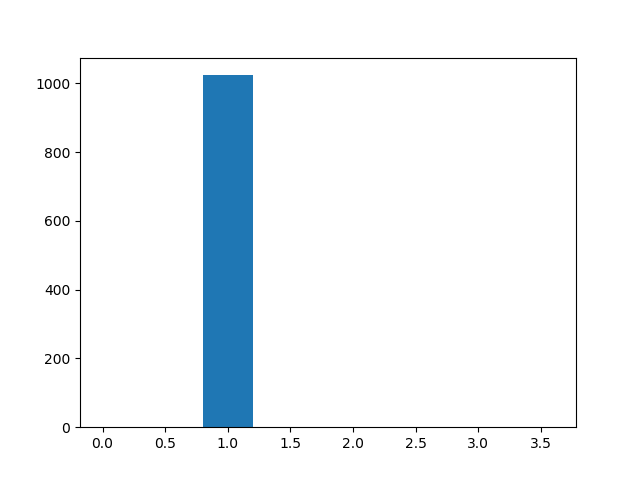

(array([    0.,     0.,  1024.,     0.,     0.,     0.,     0.,     0.,
            0.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6]),
 <a list of 9 Patch objects>)

In [603]:
fig = plt.figure()
plt.hist(np.sqrt(np.sum(X_gen ** 2, axis=1)), bins=np.arange(0, 4, 0.4))


/home/golikov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


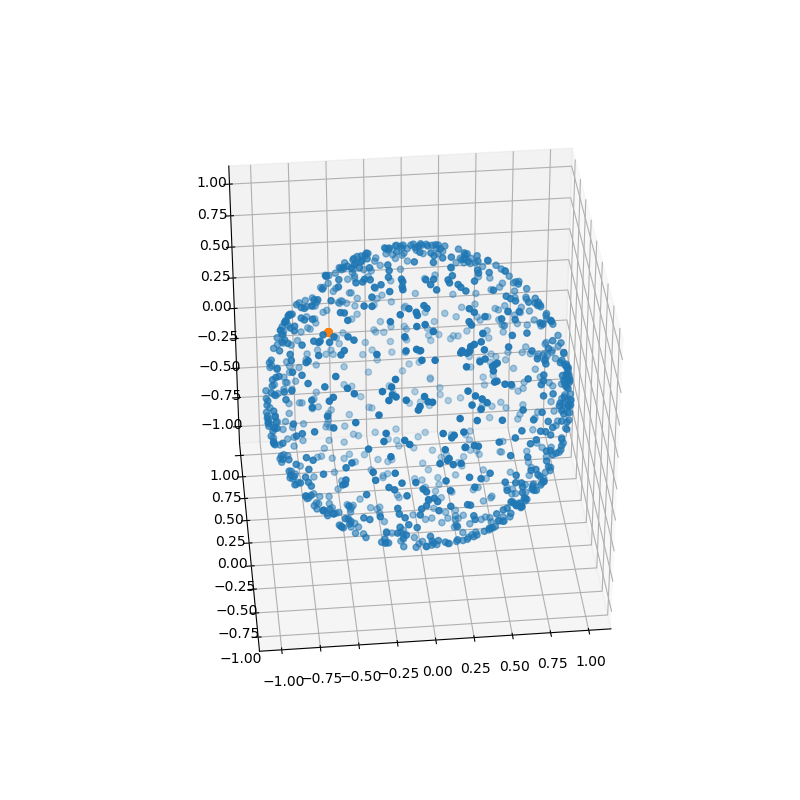

In [604]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
ax.scatter3D(X_gen[:, 0], X_gen[:, 1], X_gen[:, 2])

**WAE-MMD**

In [621]:
def kernel(X, Y, C=2*latent_dim):
    return C / (C + torch.sum((X.view(1, *X.shape) - Y.view(Y.shape[0], 1, Y.shape[1])) ** 2, dim=2))

In [622]:
def maximum_mean_discrepancy(X, Y):
    assert X.shape == Y.shape
    n = X.shape[0]
    X_kernel = kernel(X, X)
    X_term = (torch.sum(X_kernel) - torch.trace(X_kernel)) / (n * (n-1))
    Y_kernel = kernel(Y, Y)
    Y_term = (torch.sum(Y_kernel) - torch.trace(Y_kernel)) / (n * (n-1))
    XY_kernel = kernel(X, Y)
    XY_term = 2 * torch.sum(XY_kernel) / (n * n)
    return X_term + Y_term - XY_term
    

In [630]:
class WAE_MMD(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_count=2, regularization_factor=10):
        super(type(self), self).__init__()
        self.latent_dim = latent_dim
        self.regularization_factor = regularization_factor
        
        self.proposal_network = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.proposal_network.append(nn.Linear(hidden_dim, hidden_dim))
            self.proposal_network.append(nn.Softplus())
        self.proposal_mu_head = nn.Linear(hidden_dim, latent_dim)
        self.proposal_sigma_head = nn.Linear(hidden_dim, latent_dim)

        self.generative_network = nn.ModuleList([
            nn.Linear(latent_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.generative_network.append(nn.Linear(hidden_dim, hidden_dim))
            self.generative_network.append(nn.Softplus())
        self.generative_mu_head = nn.Linear(hidden_dim, input_dim)
        #self.generative_sigma_head = nn.Linear(hidden_dim, input_dim)

    def proposal_distr(self, x):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        for layer in self.proposal_network:
            x = layer(x)
        mu = self.proposal_mu_head(x)
        sigma = torch.exp(self.proposal_sigma_head(x))
        return mu, sigma

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        mu = cuda_wrapper(Variable(torch.zeros(n, self.latent_dim)))
        sigma = cuda_wrapper(Variable(torch.ones(n, self.latent_dim)))
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
        mu, sigma = distr
        n, d = mu.shape
        eps = cuda_wrapper(Variable(torch.normal(means=torch.zeros(n, K, d))))
        return (mu.view(n, 1, d) + sigma.view(n, 1, d) * eps).view(n * K, d)

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        return torch.normal(*self.prior_distr(num_samples))

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        for layer in self.generative_network:
            z = layer(z)
        mu = self.generative_mu_head(z)
        #sigma = torch.exp(self.generative_sigma_head(z))
        return mu

    def batch_loss(self, batch, K=1):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        """
        n = batch.shape[0]
        q = self.proposal_distr(batch)
        zs = self.sample_latent(q, K)
        #zs = q[0]
        zs_prior = self.sample_prior(n)
        batch_rec = self.generative_distr(zs)
        reconstruction_loss = torch.sum((batch_rec - batch) ** 2) / n
        regularization_loss = maximum_mean_discrepancy(zs, zs_prior) * self.regularization_factor
        return reconstruction_loss + regularization_loss

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        return self.generative_distr(self.sample_prior(num_samples))

In [631]:
epoch_count = 20000

latent_dim = 10
model = cuda_wrapper(WAE_MMD(n_features, hidden_dim=50, latent_dim=latent_dim, regularization_factor=10))
optimizer = optim.Adam(model.parameters())

for epoch in range(epoch_count):
    batch_gen = batch_generator(X, batch_size=256)
    cum_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.sample_latent(model.proposal_distr(X_batch_requires_grad))
        X_batch_fit = model.generative_distr(Z_batch)
        loss = model.batch_loss(X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_count += 1
    mean_loss = cum_loss / batch_count
    mean_scalar_product = cum_scalar_product / batch_count

    batch_gen = batch_generator(X_test, batch_size=256)
    cum_loss = 0
    cum_scalar_product = 0
    batch_count = 0
    for X_batch in batch_gen:
        X_batch = cuda_wrapper(Variable(X_batch))
        X_batch_requires_grad = Variable(X_batch.data, requires_grad=True)

        Z_batch = model.sample_latent(model.proposal_distr(X_batch_requires_grad))
        X_batch_fit = model.generative_distr(Z_batch)
        loss = model.batch_loss(X_batch)
        cum_loss += loss.data[0]
        
        scalar_product = torch.sum(
            autograd.grad(
                [torch.sum(X_batch_fit ** 2)], [X_batch_requires_grad], retain_graph=True
            )[0].data ** 2, dim=1
        )
        cum_scalar_product += torch.mean(scalar_product)
        
        batch_count += 1
    mean_test_loss = cum_loss / batch_count
    mean_test_scalar_product = cum_scalar_product / batch_count
    
    if (epoch + 1) % 1000 == 0:
        print(
            'epoch {}; loss = {:.4f} : {:.4f}, scalar product = {:.4f} : {:.4f}'.format(
                epoch + 1, mean_loss, mean_test_loss, 
                mean_scalar_product, mean_test_scalar_product
            )
        )


epoch 1000; loss = 0.0320 : 0.0649, scalar product = 0.5428 : 0.6482
epoch 2000; loss = 0.0072 : 0.0219, scalar product = 0.1609 : 0.1876
epoch 3000; loss = -0.0005 : 0.0059, scalar product = 0.0828 : 0.1180
epoch 4000; loss = 0.0048 : 0.0154, scalar product = 0.2077 : 0.3197
epoch 5000; loss = -0.0024 : -0.0000, scalar product = 0.1406 : 0.1514
epoch 6000; loss = -0.0050 : 0.0206, scalar product = 0.0505 : 0.0738


KeyboardInterrupt: 

**WAE-WGAN**

In [630]:
class WAE_WGAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_count=2, regularization_factor=10):
        super(type(self), self).__init__()
        self.latent_dim = latent_dim
        self.regularization_factor = regularization_factor
        
        self.proposal_generator = Generator(latent_dim*2, hidden_dim, latent_dim)
        self.proposal_discriminator = Discriminator(latent_dim, hidden_dim)
        
        self.generative_network = nn.ModuleList([
            nn.Linear(latent_dim, hidden_dim),
            nn.Softplus()
        ])
        for _ in range(hidden_count-1):
            self.generative_network.append(nn.Linear(hidden_dim, hidden_dim))
            self.generative_network.append(nn.Softplus())
        self.generative_mu_head = nn.Linear(hidden_dim, input_dim)
        #self.generative_sigma_head = nn.Linear(hidden_dim, input_dim)

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        mu = cuda_wrapper(Variable(torch.zeros(n, self.latent_dim)))
        sigma = cuda_wrapper(Variable(torch.ones(n, self.latent_dim)))
        return mu, sigma

    def sample_latent(self):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
        return 

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        return torch.normal(*self.prior_distr(num_samples))

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        for layer in self.generative_network:
            z = layer(z)
        mu = self.generative_mu_head(z)
        #sigma = torch.exp(self.generative_sigma_head(z))
        return mu

    def batch_loss(self, batch, K=1):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        """
        n = batch.shape[0]
        q = self.proposal_distr(batch)
        zs = self.sample_latent(q, K)
        #zs = q[0]
        zs_prior = self.sample_prior(n)
        batch_rec = self.generative_distr(zs)
        reconstruction_loss = torch.sum((batch_rec - batch) ** 2) / n
        regularization_loss = maximum_mean_discrepancy(zs, zs_prior) * self.regularization_factor
        return reconstruction_loss + regularization_loss

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        return self.generative_distr(self.sample_prior(num_samples))